In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)

In [2]:
import sys
import gym
import pylab
import random
import tensorflow as tf
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from numpy.random import seed
from keras import backend as K


EPISODES = 10000



np.random.seed(123)
random.seed(456)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K

tf.set_random_seed(789)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.action_table = [0,1,-4,4]
        self.lam = 0
        self.alpha = 0.1
        self.target_state = 11

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 1
        self.actor_lr = 0.005
        self.critic_lr = 0.005

        # create model for policy network
        self.actor_1 = self.build_actor()
        self.actor_2 = self.build_actor()
        self.critic = self.build_critic()
        self.critic2 = self.build_critic2()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        #actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size*2, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
    
    def build_critic2(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size*2, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
        

    # using the output of policy network, pick action stochastically
    def get_action_1(self, state):
        policy = self.actor_1.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def get_action_2(self, state):
        policy = self.actor_2.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def get_maxaction_1(self,state):
        policy = self.actor_1.predict(state, batch_size=1).flatten()
        return np.argmax(policy)
    
    def get_maxaction_2(self,state):
        policy = self.actor_2.predict(state, batch_size=1).flatten()
        return np.argmax(policy)

    # update policy network every episode
    def train_model(self, state1,state2, action1,action2,reward1,reward2, next_state1,next_state2,done):
        
        full_state = np.concatenate([state1,state2],axis = 1)
        #print(np.shape(full_state))
        full_next_state = np.concatenate([next_state1,next_state2], axis = 1)
        
        target = np.zeros((1, self.value_size))
        
        advantages_1 = np.zeros((1, self.action_size))
        advantages_2 = np.zeros((1, self.action_size))
        
        target2 = np.zeros((1, self.value_size))     

        value = self.critic.predict(full_state)[0]
        value2 = self.critic2.predict(full_state)[0]
        next_value = self.critic.predict(full_next_state)[0]
        next_value2 = self.critic2.predict(full_next_state)[0]
        
        reward1 = reward1 + self.lam*(reward2 - self.alpha)

        if done:
            advantages_1[0][action1] = -1*(reward1 - value)
            advantages_2[0][action2] = -1*(reward1 - value)
            
            target[0][0] = reward1
            target2[0][0] = reward2
        else:
            advantages_1[0][action1] = -1*(reward1 + self.discount_factor * (next_value) - value)
            advantages_2[0][action2] = -1*(reward1 + self.discount_factor * (next_value) - value)
            target[0][0] = reward1 + self.discount_factor * next_value
            target2[0][0] = reward2 + self.discount_factor * next_value2
#             if np.where(next_state == 1.0)[1][0] == self.target_state:
#                 target2[0][0] = 0 + self.discount_factor * next_value2
#             else:
#                 target2[0][0] = np.where(next_state == 1.0)[1][0]/10 + self.discount_factor * next_value2            
            

        self.actor_1.fit(state1, advantages_1, epochs=1, verbose=0)
        self.actor_2.fit(state2,advantages_2,epochs=1,verbose =0)
        self.critic.fit(full_state, target, epochs=1, verbose=0)
        self.critic2.fit(full_state,target2,epochs = 1, verbose = 0)
        
        initial_state = np.zeros((1,state_size))
        initial_state[0][0] = 1
        self.lam = min(max(0,(self.lam + 0.001*(self.critic2.predict(full_state)[0] - self.alpha))), 5)
        #print(self.lam)
        
        
        
    
    def get_next(self,state,action):
        #print(state)
        state_index = np.where(state == 1.0)[1][0]
        next_state_index = state_index + self.action_table[action]
        next_state = np.zeros((1,self.state_size))

        if next_state_index > self.state_size-1 or next_state_index < 0:
            next_state_index = state_index
            next_state[0][next_state_index] = 1
        else:
            next_state[0][next_state_index] = 1
            
        if next_state_index == self.target_state:
#             reward = 0.0 - self.alpha # + (self.lam*(np.where(state == 1.0)[1][0]/10 - 0.5))  
            done = True
        else:
            done = False
#             reward = 1.0 + (self.lam*(np.where(next_state == 1.0)[1][0]/10 - self.alpha))   
        
        return next_state,done

    

def get_rewards(state1,state2):
    
    if state1 == 11 and state2 == 11:
        reward1 = 0.0
    else:
        reward1 = 1.0
        
    if state1 == 11 or state2 == 11:
        reward2 = 0
    elif state1 == state2:
        reward2 = 1
    else:
        reward2 = 0
    
    return reward1,reward2
    
    


if __name__ == "__main__":
    
    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = 16 #env.observation_space.shape[0]
    action_size = 4 #env.action_space.n
    
    total_runs = 1
    #store_final_penalty = np.zeros((1,EPISODES))
    #average_final_count = np.zeros((1,total_runs))
    #total_count = 10000
    
    for runs in range(total_runs):
        
        
#         np.random.seed(runs*100)
#         random.seed(runs*110)

#         session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        

#         tf.set_random_seed(runs*120)

#         sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#         K.set_session(sess)
        
        
        
        average_penalty = 0
        total_penalty = 0
        store_penalty = np.zeros((1,EPISODES))
        
        average_lag = 0
        total_lag = 0
        store_lag = np.zeros((1,EPISODES))
        
        opt_pol_penalty = 0
        opt_pol_count = 0



        # make A2C agent
        agent = A2CAgent(state_size, action_size)
        #print(agent.lam)
        



        scores, episodes = [], []

        for i in range(1):
            done = False
            score = 0
            #state = env.reset()
            #state = np.reshape(state, [1, state_size])
            #rand_state = random.randint(0,15)
            #state = np.zeros((1,state_size))
            #state[0][rand_state] = 1
            #state = np.reshape(state, [1, state_size])

            for e in range(EPISODES):
            #state = env.reset()
                rand_state1 = random.randint(0,state_size-1)

                state1 = np.zeros((1,state_size))
                state2 = np.zeros((1,state_size))

                state1[0][rand_state1] = 1
                state2[0][rand_state1] = 1

                #state = np.reshape(state, [1, state_size])
                for time in range(10):
                # env.render()
                
                    if state1[0][11] ==1:
                        action1 = 0
                    else:
                        action1 = agent.get_action_1(state1)
                    
                    if state2[0][11] == 1:
                        action2 = 0
                    else:
                        action2 = agent.get_action_2(state2)
                        

                    next_state1, done1 = agent.get_next(state1,action1)
                    next_state2, done2 = agent.get_next(state2,action2)

                    reward1,reward2 = get_rewards(np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

                #reward = reward if not done else -10
                    #next_state = np.reshape(next_state, [1, state_size])
                    #if e < EPISODES/20:
                    agent.train_model(state1,state2, action1, action2,reward1,reward2,next_state1, next_state2,done1 and done2)
                    #agent2.train_model(state2, action2, reward1,reward2,next_state2, done2)

                    print(np.where(state1 == 1.0)[1][0],np.where(state2 == 1.0)[1][0],action1,action2,np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])
                    #print(agent1.lam,agent2.lam)
                    state1 = next_state1
                    state2 = next_state2

                    average_penalty = average_penalty + reward2
                    average_lag = average_lag + reward1

                    if done1 and done2:
                    #print(state)
                        print("episode: {}/{}, score: {}"
                          .format(e, EPISODES, time))
                        
                        #print(agent.lam)
                        #print(agent2.lam)
                        break

                    #if len(agent.memory) > batch_size:
                        #agent.replay(batch_size)
                        
                print(agent.lam)
                total_penalty = total_penalty + average_penalty        
                store_penalty[0][e] = total_penalty/(e+1) 
                print(store_penalty[0][e])
                
                total_lag = total_lag + average_lag
                store_lag[0][e] = total_lag/(e+1)
                
                if e > EPISODES - 1000:
                    opt_pol_count = opt_pol_count + 1
                    opt_pol_penalty = opt_pol_penalty + average_penalty
                
                
                #if np.mean(store_penalty[0][e-100:e]) < agent.alpha+0.1:
                        #sys.exit()
                #print(store_penalty[0][e])
                average_penalty = 0
                average_lag = 0

                print('*******************************')
        
#             average_count = 0    
#             for count in range(total_count):
#                 state1 = np.zeros((1,state_size))
#                 state2 = np.zeros((1,state_size))

#                 st = random.randint(0,state_size-1)

#                 state1[0][st] = 1
#                 state2[0][st] = 1

#                 penalty_count = 0

#                 for t in range(10):
#                     action1 = agent.get_maxaction_1(state1)
#                     action2 = agent.get_maxaction_2(state2)

#                     next_state1,done1 = agent.get_next(state1,action1)
#                     next_state2,done2 = agent.get_next(state2,action2)

#                     reward1,reward2 = get_rewards(np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

#                     if count == 8000:
#                         print(np.where(state1 == 1.0)[1][0],np.where(state2 == 1.0)[1][0],action1,action2,np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

#                     state1 = next_state1
#                     state2 = next_state2

#                     penalty_count = penalty_count + reward2

#                     if done1 and done2:
#                         #print(penalty_count)
#                         #print('****************')
#                         #print("Success")
#                         break

#                 average_count = average_count + penalty_count
#             #print(average_count/(count+1))
            
#             print(runs,average_count/total_count)
            
#         store_final_penalty = store_final_penalty + store_penalty
#         average_final_count[0][runs] = (average_count/total_count)

    #print(np.sum(average_final_count)/total_runs)
        

                
        

/home/raghuram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


14 14 3 1 14 15
14 15 2 0 10 15
10 15 1 2 11 11
episode: 0/10000, score: 2
0
0.0
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1/10000, score: 1
0
0.5
*******************************
13 13 2 1 9 14
9 14 0 2 9 10
9 10 1 1 10 11
10 11 1 0 11 11
episode: 2/10000, score: 3
0
0.3333333333333333
*******************************
12 12 2 2 8 8
8 8 2 2 4 4
4 4 1 1 5 5
5 5 3 3 9 9
9 9 3 0 13 9
13 9 0 0 13 9
13 9 0 3 13 13
13 13 3 2 13 9
13 9 2 1 9 10
9 10 2 1 5 11
0
1.5
*******************************
1 1 2 3 1 5
1 5 3 0 5 5
5 5 1 0 6 5
6 5 1 3 7 9
7 9 2 3 3 13
3 13 0 1 3 14
3 14 0 1 3 15
3 15 2 3 3 15
3 15 0 2 3 11
3 11 0 0 3 11
0
1.4
*******************************
3 3 3 1 7 4
7 4 2 0 3 4
3 4 1 3 4 8
4 8 0 2 4 4
4 4 0 2 4 0
4 0 0 3 4 4
4 4 3 2 8 0
8 0 1 2 9 0
9 0 1 3 10 4
10 4 0 2 10 0
0
1.5
*******************************
10 10 3 1 14 11
14 11 1 0 15 11
15 11 3 0 15 11
15 11 3 0 15 11
15 11 1 0 15 11
15 11 0 0 15 11
15 11 1 0 15 11
15 11 1 0 15 11
15 11 2 0 11 11
epi

0 11 2 0 0 11
0 11 2 0 0 11
0 11 2 0 0 11
0 11 0 0 0 11
[0.45148882]
1.1304347826086956
*******************************
14 14 1 2 15 10
15 10 3 3 15 14
15 14 2 2 11 10
11 10 0 0 11 10
11 10 0 1 11 11
episode: 46/10000, score: 4
[0.4623879]
1.1063829787234043
*******************************
3 3 2 3 3 7
3 7 2 2 3 3
3 3 2 0 3 3
3 3 2 0 3 3
3 3 0 1 3 4
3 4 0 2 3 0
3 0 2 1 3 1
3 1 1 3 4 5
4 5 2 2 0 1
0 1 0 3 0 5
[0.48259377]
1.1458333333333333
*******************************
4 4 0 2 4 0
4 0 2 2 0 0
0 0 0 2 0 0
0 0 0 2 0 0
0 0 1 3 1 4
1 4 0 2 1 0
1 0 2 2 1 0
1 0 0 1 1 1
1 1 2 2 1 1
1 1 2 1 1 2
[0.5056422]
1.2244897959183674
*******************************
7 7 3 3 11 11
episode: 49/10000, score: 0
[0.5071874]
1.2
*******************************
15 15 2 2 11 11
episode: 50/10000, score: 0
[0.5090708]
1.1764705882352942
*******************************
6 6 2 1 2 7
2 7 0 3 2 11
2 11 3 0 6 11
6 11 2 0 2 11
2 11 0 0 2 11
2 11 1 0 3 11
3 11 0 0 3 11
3 11 1 0 4 11
4 11 3 0 8 11
8 11 3 0 12 11
[0.5222

9 12 0 1 9 13
9 13 3 1 13 14
13 14 1 2 14 10
14 10 1 1 15 11
15 11 3 0 15 11
15 11 2 0 11 11
episode: 95/10000, score: 6
[0.82470614]
0.8541666666666666
*******************************
14 14 1 3 15 14
15 14 2 2 11 10
11 10 0 1 11 11
episode: 96/10000, score: 2
[0.82450956]
0.845360824742268
*******************************
9 9 3 1 13 10
13 10 1 1 14 11
14 11 3 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 97/10000, score: 4
[0.8222844]
0.8367346938775511
*******************************
2 2 3 3 6 6
6 6 3 1 10 7
10 7 3 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 98/10000, score: 4
[0.8212573]
0.8383838383838383
*******************************
7 7 1 3 8 11
8 11 0 0 8 11
8 11 3 0 12 11
12 11 3 0 12 11
12 11 0 0 12 11
12 11 1 0 13 11
13 11 1 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 99/10000, score: 8
[0.81910276]
0.83
*******************************
9 9 3 1 13 10
13 10 3 1 13 11
13 11 2 0 9 11
9 11 3 0 13 11
13 11 3 0 13 11
13 11 1 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
epis

2 2 0 3 2 6
2 6 1 1 3 7
3 7 1 3 4 11
4 11 1 0 5 11
5 11 3 0 9 11
9 11 1 0 10 11
10 11 1 0 11 11
episode: 146/10000, score: 7
[0.80677736]
0.7210884353741497
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 3 3 11 11
episode: 147/10000, score: 2
[0.80748063]
0.7297297297297297
*******************************
15 15 2 2 11 11
episode: 148/10000, score: 0
[0.80770975]
0.7248322147651006
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 149/10000, score: 3
[0.80915576]
0.72
*******************************
5 5 3 1 9 6
9 6 3 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 150/10000, score: 4
[0.8096046]
0.7152317880794702
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode: 151/10000, score: 1
[0.8101475]
0.7171052631578947
*******************************
5 5 3 1 9 6
9 6 0 1 9 7
9 7 3 3 13 11
13 11 1 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 152/10000, score: 5
[0.8104197]
0.7124183006535948
************

7 7 3 3 11 11
episode: 203/10000, score: 2
[0.8379521]
0.6666666666666666
*******************************
4 4 1 1 5 5
5 5 3 1 9 6
9 6 3 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 204/10000, score: 5
[0.83864176]
0.6682926829268293
*******************************
15 15 2 1 11 15
11 15 0 2 11 11
episode: 205/10000, score: 1
[0.8388551]
0.6650485436893204
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode: 206/10000, score: 1
[0.8394108]
0.6666666666666666
*******************************
15 15 3 2 15 11
15 11 2 0 11 11
episode: 207/10000, score: 1
[0.83945566]
0.6634615384615384
*******************************
4 4 1 1 5 5
5 5 3 1 9 6
9 6 3 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 208/10000, score: 5
[0.840178]
0.6650717703349283
*******************************
15 15 0 2 15 11
15 11 2 0 11 11
episode: 209/10000, score: 1
[0.8401941]
0.6619047619047619
*******************************
14 14 1 2 15 10
15 10 0 1 15 11
15 11 2 0 11 11
epi

1 1 3 1 5 2
5 2 3 3 9 6
9 6 3 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 260/10000, score: 5
[0.8591729]
0.6206896551724138
*******************************
11 11 0 0 11 11
episode: 261/10000, score: 0
[0.859023]
0.6183206106870229
*******************************
2 2 3 3 6 6
6 6 0 1 6 7
6 7 1 3 7 11
7 11 3 0 11 11
episode: 262/10000, score: 3
[0.8609769]
0.6197718631178707
*******************************
11 11 0 0 11 11
episode: 263/10000, score: 0
[0.86082006]
0.6174242424242424
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 3 3 12 6
12 6 1 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 264/10000, score: 6
[0.86218596]
0.6150943396226415
*******************************
15 15 2 2 11 11
episode: 265/10000, score: 0
[0.8621908]
0.6127819548872181
*******************************
15 15 2 2 11 11
episode: 266/10000, score: 0
[0.86218697]
0.6104868913857678
*******************************
10 10 1 1 11 11
episode: 267/10000, score: 0
[0.8620895]

4 2 3 3 8 6
8 6 3 1 12 7
12 7 1 3 13 11
13 11 1 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 320/10000, score: 7
[0.8652204]
0.5607476635514018
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode: 321/10000, score: 1
[0.86566156]
0.562111801242236
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 322/10000, score: 2
[0.86609876]
0.5603715170278638
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 323/10000, score: 1
[0.86680186]
0.5617283950617284
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode: 324/10000, score: 1
[0.8672441]
0.563076923076923
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 325/10000, score: 3
[0.8674609]
0.5613496932515337
*******************************
0 0 1 1 1 1
1 1 1 1 2 2
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 326/10000, score: 4
[0.86997086]
0.5688073394495413
*******************************
8 8 3 1 12 9
12 9 1 

12 10 1 1 13 11
13 11 1 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 378/10000, score: 5
[0.86628264]
0.5197889182058048
*******************************
10 10 1 1 11 11
episode: 379/10000, score: 0
[0.86621016]
0.5184210526315789
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 380/10000, score: 4
[0.86567694]
0.5170603674540682
*******************************
14 14 1 2 15 10
15 10 2 2 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 381/10000, score: 3
[0.8653258]
0.5157068062827225
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 382/10000, score: 4
[0.8648256]
0.5143603133159269
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 383/10000, score: 2
[0.86623085]
0.515625
*******************************
10 10 1 1 11 11
episode: 384/10000, score: 0
[0.8661696]
0.5142857142857142
*******************************
13 13 1 1 14 14


14 9 1 1 15 10
15 10 2 1 11 11
episode: 437/10000, score: 3
[0.8667741]
0.4840182648401826
*******************************
15 15 2 1 11 15
11 15 0 2 11 11
episode: 438/10000, score: 1
[0.86669344]
0.48291571753986334
*******************************
10 10 1 1 11 11
episode: 439/10000, score: 0
[0.86665654]
0.4818181818181818
*******************************
11 11 0 0 11 11
episode: 440/10000, score: 0
[0.8665128]
0.48072562358276644
*******************************
10 10 1 1 11 11
episode: 441/10000, score: 0
[0.8664698]
0.4796380090497738
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 3 3 12 6
12 6 1 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 442/10000, score: 6
[0.8663179]
0.4785553047404063
*******************************
15 15 2 2 11 11
episode: 443/10000, score: 0
[0.8662359]
0.4774774774774775
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 444/10000, score: 2
[0.8662765]
0.4764044943820225
***************************

7 7 3 3 11 11
episode: 501/10000, score: 0
[0.8823314]
0.46613545816733065
*******************************
15 15 2 2 11 11
episode: 502/10000, score: 0
[0.8823307]
0.46520874751491054
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 503/10000, score: 3
[0.88370717]
0.4642857142857143
*******************************
10 10 1 1 11 11
episode: 504/10000, score: 0
[0.8837171]
0.4633663366336634
*******************************
4 4 1 1 5 5
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 505/10000, score: 3
[0.8844662]
0.4644268774703557
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 506/10000, score: 2
[0.8863988]
0.46548323471400394
*******************************
7 7 3 3 11 11
episode: 507/10000, score: 0
[0.8863653]
0.4645669291338583
*******************************
8 8 3 1 12 9
12 9 1 1 13 10
13 10 1 1 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 508/10000, score: 4
[0.88771456]
0.4636542239685658
*************

12 9 1 1 13 10
13 10 1 1 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 563/10000, score: 4
[0.907089]
0.4592198581560284
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 3 3 12 6
12 6 1 1 13 7
13 7 1 3 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 564/10000, score: 6
[0.90604967]
0.4584070796460177
*******************************
1 1 1 1 2 2
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 565/10000, score: 3
[0.90736204]
0.46113074204946997
*******************************
4 4 3 1 8 5
8 5 3 1 12 6
12 6 3 1 12 7
12 7 1 3 13 11
13 11 1 0 14 11
14 11 1 0 15 11
15 11 2 0 11 11
episode: 566/10000, score: 6
[0.9057977]
0.4603174603174603
*******************************
13 13 1 1 14 14
14 14 1 2 15 10
15 10 2 1 11 11
episode: 567/10000, score: 2
[0.9060602]
0.4612676056338028
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 568/10000, score: 1
[0.9062241]
0.46045694200351495
*******************************
10 10 1 1 11 11
episode: 569/10000, score: 0
[0.90609217

5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 626/10000, score: 2
[0.90942425]
0.44178628389154706
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 627/10000, score: 3
[0.9095568]
0.4410828025477707
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 628/10000, score: 1
[0.90967923]
0.44038155802861684
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 629/10000, score: 3
[0.9097766]
0.4396825396825397
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 630/10000, score: 3
[0.90959424]
0.43898573692551507
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 631/10000, score: 2
[0.90900517]
0.43829113924050633
*******************************
15 15 2 2 11 11
episode: 632/10000, score: 0
[0.90886027]
0.43759873617693523
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 633/10000

7 7 3 3 11 11
episode: 690/10000, score: 1
[0.923941]
0.43270622286541244
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 691/10000, score: 1
[0.9237628]
0.4320809248554913
*******************************
11 11 0 0 11 11
episode: 692/10000, score: 0
[0.92363274]
0.4314574314574315
*******************************
15 15 2 2 11 11
episode: 693/10000, score: 0
[0.92354393]
0.430835734870317
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 694/10000, score: 1
[0.92443603]
0.4316546762589928
*******************************
10 10 1 1 11 11
episode: 695/10000, score: 0
[0.9243522]
0.43103448275862066
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 696/10000, score: 1
[0.9244241]
0.430416068866571
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 697/10000, score: 3
[0.9246907]
0.4297994269340974
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 698/10000, score: 1

13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 759/10000, score: 3
[0.9384435]
0.4236842105263158
*******************************
10 10 1 1 11 11
episode: 760/10000, score: 0
[0.93832994]
0.4231274638633377
*******************************
13 13 1 1 14 14
14 14 1 2 15 10
15 10 2 1 11 11
episode: 761/10000, score: 2
[0.9385323]
0.4238845144356955
*******************************
15 15 2 2 11 11
episode: 762/10000, score: 0
[0.93842065]
0.4233289646133683
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 763/10000, score: 3
[0.9375942]
0.42277486910994766
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 764/10000, score: 3
[0.9371746]
0.4222222222222222
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 765/10000, score: 2
[0.93660355]
0.4216710182767624
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 766/10000, score: 1
[0.93648744]
0.42112125162

7 7 3 3 11 11
episode: 828/10000, score: 3
[0.9557242]
0.41857659831121835
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 829/10000, score: 1
[0.9556335]
0.41807228915662653
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 830/10000, score: 1
[0.95553935]
0.4175691937424789
*******************************
7 7 3 3 11 11
episode: 831/10000, score: 0
[0.95545006]
0.4170673076923077
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 832/10000, score: 2
[0.95839626]
0.4189675870348139
*******************************
4 4 1 1 5 5
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 833/10000, score: 3
[0.9592295]
0.4196642685851319
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 834/10000, score: 3
[0.9590937]
0.41916167664670656
*******************************
7 7 3 3 11 11
episode: 835/10000, score: 0
[0.9589936]
0.41866028708133973
*****************************

3 6 3 1 7 7
7 7 3 3 11 11
episode: 892/10000, score: 2
[0.97379965]
0.4143337066069429
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 893/10000, score: 4
[0.9734646]
0.41387024608501116
*******************************
11 11 0 0 11 11
episode: 894/10000, score: 0
[0.97336686]
0.4134078212290503
*******************************
1 1 3 1 5 2
5 2 3 2 9 2
9 2 1 3 10 6
10 6 1 1 11 7
11 7 0 3 11 11
episode: 895/10000, score: 4
[0.97344273]
0.41294642857142855
*******************************
15 15 2 2 11 11
episode: 896/10000, score: 0
[0.97338915]
0.4124860646599777
*******************************
3 3 3 2 7 3
7 3 3 0 11 3
11 3 0 3 11 7
11 7 0 3 11 11
episode: 897/10000, score: 3
[0.97420806]
0.41202672605790647
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 898/10000, score: 2
[0.97376645]
0.41156840934371525
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 899/10000, score: 1
[0.9736

8 0 1 1 9 1
9 1 1 1 10 2
10 2 1 3 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 957/10000, score: 5
[0.96817124]
0.3935281837160752
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 958/10000, score: 1
[0.968027]
0.3931178310740355
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 959/10000, score: 1
[0.9678821]
0.3927083333333333
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 960/10000, score: 3
[0.9676045]
0.3922996878251821
*******************************
13 13 1 1 14 14
14 14 1 2 15 10
15 10 2 1 11 11
episode: 961/10000, score: 2
[0.96742886]
0.39293139293139295
*******************************
4 4 3 1 8 5
8 5 2 1 4 6
4 6 3 1 8 7
8 7 1 3 9 11
9 11 1 0 10 11
10 11 1 0 11 11
episode: 962/10000, score: 5
[0.96767545]
0.3925233644859813
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 963/10000, score: 1
[0.967705]
0.3921161825726141
*******************************
1 1 3 1 5 2
5 

11 3 0 1 11 4
11 4 0 1 11 5
11 5 0 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1021/10000, score: 9
[0.9677308]
0.3816046966731898
*******************************
11 11 0 0 11 11
episode: 1022/10000, score: 0
[0.9676066]
0.3812316715542522
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1023/10000, score: 3
[0.967447]
0.380859375
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1024/10000, score: 2
[0.96951056]
0.3824390243902439
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1025/10000, score: 1
[0.9693418]
0.3820662768031189
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1026/10000, score: 3
[0.9691703]
0.38169425511197663
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1027/10000, score: 3
[0.9689376]
0.38132295719844356
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 1

3 6 3 1 7 7
7 7 3 3 11 11
episode: 1085/10000, score: 2
[0.98080635]
0.3784530386740331
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1086/10000, score: 1
[0.9805913]
0.3781048758049678
*******************************
7 7 3 3 11 11
episode: 1087/10000, score: 0
[0.9804705]
0.37775735294117646
*******************************
11 11 0 0 11 11
episode: 1088/10000, score: 0
[0.9803738]
0.3774104683195592
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1089/10000, score: 1
[0.9805166]
0.3779816513761468
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1090/10000, score: 2
[0.980192]
0.37763519706691107
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1091/10000, score: 1
[0.9800489]
0.3772893772893773
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1092/10000, score: 1
[0.9799111]
0.37694419030192133
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1093/10000

15 10 2 1 11 11
episode: 1148/10000, score: 3
[0.97464395]
0.36553524804177545
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1149/10000, score: 1
[0.97533613]
0.3660869565217391
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1150/10000, score: 1
[0.9751639]
0.365768896611642
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1151/10000, score: 2
[0.9747716]
0.3654513888888889
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 1152/10000, score: 1
[0.974581]
0.36513443191673894
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1153/10000, score: 2
[0.9770301]
0.3665511265164645
*******************************
10 10 1 1 11 11
episode: 1154/10000, score: 0
[0.9769305]
0.36623376623376624
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1155/10000, score: 2
[0.9789214]
0.36678200692041524
*******************************
4 4 3 1 8 5
8 

9 9 1 1 10 10
10 10 1 1 11 11
episode: 1215/10000, score: 1
[0.9940952]
0.3675986842105263
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1216/10000, score: 1
[0.9948402]
0.36811832374691866
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1217/10000, score: 2
[0.9974891]
0.3694581280788177
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1218/10000, score: 2
[0.9971501]
0.36915504511895
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1219/10000, score: 1
[0.99793166]
0.369672131147541
*******************************
10 10 1 1 11 11
episode: 1220/10000, score: 0
[0.99783754]
0.36936936936936937
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1221/10000, score: 2
[1.0004995]
0.3707037643207856
*******************************
15 15 2 3 11 15
11 15 0 2 11 11
episode: 1222/10000, score: 1
[1.0005242]
0.3704006541291905
*****************************

10 7 1 3 11 11
episode: 1280/10000, score: 3
[1.0017039]
0.36455893832943015
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1281/10000, score: 2
[1.0015255]
0.36427457098283933
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1282/10000, score: 2
[1.0013262]
0.36399064692127825
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1283/10000, score: 3
[1.0011455]
0.3637071651090343
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1284/10000, score: 5
[1.0005594]
0.36342412451361866
*******************************
15 15 2 2 11 11
episode: 1285/10000, score: 0
[1.0004996]
0.3631415241057543
*******************************
11 11 0 0 11 11
episode: 1286/10000, score: 0
[1.0003934]
0.3628593628593629
*******************************
10 10 1 1 11 11
episode: 1287/10000, score: 0
[1.0003026]
0.36257763975155277
**

9 6 1 1 10 7
10 7 1 3 11 11
episode: 1343/10000, score: 3
[1.003966]
0.3586309523809524
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1344/10000, score: 2
[1.0053501]
0.3591078066914498
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1345/10000, score: 2
[1.0066917]
0.35958395245170877
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1346/10000, score: 3
[1.0061469]
0.3593170007423905
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1347/10000, score: 4
[1.0062661]
0.3590504451038576
*******************************
11 11 0 0 11 11
episode: 1348/10000, score: 0
[1.0061184]
0.3587842846553002
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1349/10000, score: 2
[1.0056964]
0.3585185185185185
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 

15 10 2 1 11 11
episode: 1406/10000, score: 1
[0.99926925]
0.3503909026297086
*******************************
11 11 0 0 11 11
episode: 1407/10000, score: 0
[0.9991811]
0.35014204545454547
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1408/10000, score: 5
[0.9984032]
0.34989354151880764
*******************************
10 10 1 1 11 11
episode: 1409/10000, score: 0
[0.9983078]
0.349645390070922
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 1410/10000, score: 1
[0.99820566]
0.3493975903614458
*******************************
12 12 1 2 13 8
13 8 1 3 14 12
14 12 1 2 15 8
15 8 2 3 11 12
11 12 0 2 11 8
11 8 0 2 11 4
11 4 0 1 11 5
11 5 0 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1411/10000, score: 9
[0.997354]
0.34915014164305946
*******************************
15 15 2 2 11 11
episode: 1412/10000, score: 0
[0.9972763]
0.3489030431705591
*******************************
1 1 3 1 5 2
5 2 3 

3 3 3 3 7 7
7 7 3 3 11 11
episode: 1469/10000, score: 1
[0.9975169]
0.34285714285714286
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1470/10000, score: 5
[0.9966154]
0.34262406526172673
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1471/10000, score: 2
[0.9963208]
0.3423913043478261
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1472/10000, score: 2
[0.997779]
0.3428377460964019
*******************************
7 7 3 3 11 11
episode: 1473/10000, score: 0
[0.99767125]
0.34260515603799185
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 1474/10000, score: 1
[0.9974805]
0.3423728813559322
*******************************
10 10 1 1 11 11
episode: 1475/10000, score: 0
[0.9973849]
0.3421409214092141
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1476/10000, score: 1
[0.9971879]
0.34190927555856465
****

11 6 0 1 11 7
11 7 0 3 11 11
episode: 1531/10000, score: 4
[1.0014728]
0.3387728459530026
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 1532/10000, score: 1
[1.001519]
0.3385518590998043
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1533/10000, score: 1
[1.0022691]
0.3389830508474576
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1534/10000, score: 1
[1.0030098]
0.33941368078175893
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1535/10000, score: 5
[1.0027242]
0.3391927083333333
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1536/10000, score: 2
[1.0043938]
0.33962264150943394
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1537/10000, score: 2
[1.0041883]
0.33940182054616386
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 

10 7 1 3 11 11
episode: 1594/10000, score: 2
[1.0045084]
0.3341692789968652
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1595/10000, score: 3
[1.0044495]
0.33395989974937346
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1596/10000, score: 3
[1.0044272]
0.3337507827175955
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1597/10000, score: 2
[1.0042691]
0.3335419274092616
*******************************
10 10 1 1 11 11
episode: 1598/10000, score: 0
[1.0042238]
0.3333333333333333
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1599/10000, score: 2
[1.0040367]
0.333125
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1600/10000, score: 2
[1.005819]
0.33354153653966273
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1601/10000, score: 3
[1.0057424]
0.333333333

13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 1656/10000, score: 2
[0.9974739]
0.3264936632468316
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1657/10000, score: 3
[0.99704754]
0.32629674306393247
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 1658/10000, score: 1
[0.99686086]
0.32610006027727545
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1659/10000, score: 5
[0.9962237]
0.32590361445783134
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1660/10000, score: 2
[0.9958976]
0.3257074051776038
*******************************
7 7 3 3 11 11
episode: 1661/10000, score: 0
[0.99579686]
0.32551143200962696
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1662/10000, score: 3
[0.9955059]
0.3253156945279615
*******************************
6 6 3 1 10 7
10 7 1 

12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1717/10000, score: 5
[0.9878367]
0.31955762514551805
*******************************
7 7 3 3 11 11
episode: 1718/10000, score: 0
[0.9877348]
0.3193717277486911
*******************************
10 10 1 1 11 11
episode: 1719/10000, score: 0
[0.98762685]
0.3191860465116279
*******************************
7 7 3 3 11 11
episode: 1720/10000, score: 0
[0.98752356]
0.3190005810575247
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1721/10000, score: 5
[0.986994]
0.31881533101045295
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 1722/10000, score: 2
[0.9868353]
0.3186302959953569
*******************************
15 15 2 2 11 11
episode: 1723/10000, score: 0
[0.9867392]
0.31844547563805103
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1724/10000, score: 1
[0.9874

10 7 1 3 11 11
episode: 1780/10000, score: 3
[0.9841383]
0.31443009545199324
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1781/10000, score: 1
[0.9839545]
0.31425364758698093
*******************************
10 10 1 1 11 11
episode: 1782/10000, score: 0
[0.9838602]
0.3140773976444195
*******************************
15 15 2 2 11 11
episode: 1783/10000, score: 0
[0.98377377]
0.31390134529147984
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1784/10000, score: 4
[0.9830796]
0.3137254901960784
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1785/10000, score: 2
[0.98433906]
0.3141097424412094
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 1786/10000, score: 5
[0.98384196]
0.3139339675433688
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1787/10

13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 1842/10000, score: 2
[0.9828413]
0.30927835051546393
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 1843/10000, score: 2
[0.9826246]
0.3091106290672451
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1844/10000, score: 1
[0.98309344]
0.3094850948509485
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1845/10000, score: 1
[0.9828818]
0.30931744312026005
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1846/10000, score: 1
[0.9837689]
0.30969139144558744
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 1847/10000, score: 3
[0.9834638]
0.30952380952380953
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 1848/10000, score: 1
[0.9832636]
0.30935640886965926
*******************************
7 7 3 3 11 11
episode: 1849/10000, score: 0
[0.98316145]
0.3091891891891892
***

15 15 2 2 11 11
episode: 1910/10000, score: 0
[0.9992885]
0.31187859759288333
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 1911/10000, score: 2
[1.0011485]
0.3122384937238494
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1912/10000, score: 1
[1.0018175]
0.31259801359121797
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 1913/10000, score: 1
[1.0014741]
0.3124346917450366
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1914/10000, score: 1
[1.0021629]
0.3127937336814621
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 1915/10000, score: 3
[1.0020419]
0.3126304801670146
*******************************
7 7 3 3 11 11
episode: 1916/10000, score: 0
[1.0018604]
0.3124673969744392
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1917/10000, score: 2
[1.0011181]
0.31230448383733056
*****************************

0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1979/10000, score: 4
[1.0265585]
0.31666666666666665
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1980/10000, score: 1
[1.0273541]
0.31701161029782937
*******************************
7 7 3 3 11 11
episode: 1981/10000, score: 0
[1.0272388]
0.3168516649848638
*******************************
11 11 0 0 11 11
episode: 1982/10000, score: 0
[1.0271221]
0.3166918809884014
*******************************
11 11 0 0 11 11
episode: 1983/10000, score: 0
[1.0270057]
0.3165322580645161
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1984/10000, score: 3
[1.0265956]
0.3163727959697733
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 1985/10000, score: 3
[1.0258505]
0.3162134944612286
*******************************
11 11 0 0 11 11
episode: 1986/10000, score: 0
[1.0257373]
0.3160543532964268
**************************

10 7 1 3 11 11
episode: 2046/10000, score: 3
[1.0446614]
0.3180263800683928
*******************************
10 10 1 1 11 11
episode: 2047/10000, score: 0
[1.0445577]
0.31787109375
*******************************
7 7 3 3 11 11
episode: 2048/10000, score: 0
[1.0444589]
0.31771595900439237
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 2049/10000, score: 1
[1.044245]
0.3175609756097561
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2050/10000, score: 3
[1.043887]
0.3174061433447099
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2051/10000, score: 2
[1.0435915]
0.3172514619883041
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2052/10000, score: 2
[1.0433059]
0.3170969313200195
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2053/10000, score: 1
[1.04311]
0.3169425511197663
*******************************
2 2 1 3 3 6
3 6 1 1 4

9 6 1 1 10 7
10 7 1 3 11 11
episode: 2109/10000, score: 4
[1.0554683]
0.3180094786729858
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2110/10000, score: 2
[1.0582865]
0.31880625296068216
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 2111/10000, score: 2
[1.0596385]
0.3191287878787879
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 2112/10000, score: 2
[1.0611159]
0.31945101751064836
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2113/10000, score: 1
[1.0619831]
0.3197729422894986
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2114/10000, score: 4
[1.0618317]
0.31962174940898347
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2115/10000, score: 2
[1.0646613]
0.32041587901701324
*******************************
15 15 2 2 11 11
episode: 2116/10000, score: 0
[1.0646044]
0.320

10 7 1 3 11 11
episode: 2172/10000, score: 3
[1.0720462]
0.3189139438564197
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2173/10000, score: 3
[1.0716274]
0.3187672493100276
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2174/10000, score: 3
[1.0713154]
0.31862068965517243
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2175/10000, score: 1
[1.0721384]
0.31893382352941174
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2176/10000, score: 2
[1.0718291]
0.3187873220027561
*******************************
10 10 1 1 11 11
episode: 2177/10000, score: 0
[1.0717224]
0.3186409550045914
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2178/10000, score: 1
[1.0725256]
0.3189536484625975
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 2179/10000, score: 1
[1.0723317]
0.31880733944954126
************

7 7 3 3 11 11
episode: 2239/10000, score: 0
[1.0895178]
0.3200892857142857
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2240/10000, score: 1
[1.0893189]
0.31994645247657294
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2241/10000, score: 2
[1.0890179]
0.3198037466547725
*******************************
7 7 3 3 11 11
episode: 2242/10000, score: 0
[1.0889179]
0.31966116807846634
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2243/10000, score: 2
[1.0916137]
0.3204099821746881
*******************************
11 11 0 0 11 11
episode: 2244/10000, score: 0
[1.0915129]
0.32026726057906457
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2245/10000, score: 3
[1.0910971]
0.3201246660730187
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2246/10000, score: 1
[1.0908984]
0.31998219848687137
*******************************
6 6 3 1 10

15 10 2 1 11 11
episode: 2307/10000, score: 2
[1.0935019]
0.317157712305026
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2308/10000, score: 3
[1.093096]
0.3170203551320918
*******************************
15 15 2 2 11 11
episode: 2309/10000, score: 0
[1.0929968]
0.3168831168831169
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2310/10000, score: 1
[1.0937986]
0.3171787105149286
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 2311/10000, score: 2
[1.0955005]
0.31747404844290655
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2312/10000, score: 2
[1.0952016]
0.31733679204496323
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2313/10000, score: 1
[1.0960026]
0.3176318063958513
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2314/10000, score: 1
[1.0958062]
0.3174946004319654
*******************************
4 4 3 1 8 

7 7 3 3 11 11
episode: 2371/10000, score: 0
[1.1184534]
0.3199831365935919
*******************************
11 11 0 0 11 11
episode: 2372/10000, score: 0
[1.1183462]
0.3198482932996207
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 2373/10000, score: 1
[1.118143]
0.3197135636057287
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2374/10000, score: 1
[1.1189473]
0.32
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2375/10000, score: 1
[1.1187472]
0.31986531986531985
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2376/10000, score: 2
[1.1214485]
0.3205721497686159
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2377/10000, score: 3
[1.1210579]
0.32043734230445753
*******************************
15 15 2 2 11 11
episode: 2378/10000, score: 0
[1.1209589]
0.3203026481715006
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
epi

15 10 2 1 11 11
episode: 2434/10000, score: 3
[1.1257668]
0.3186858316221766
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2435/10000, score: 4
[1.1253638]
0.3185550082101806
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2436/10000, score: 2
[1.1251584]
0.31842429216249485
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2437/10000, score: 1
[1.1249115]
0.31829368334700575
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 2438/10000, score: 1
[1.1247867]
0.31816318163181634
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2439/10000, score: 1
[1.1245297]
0.3180327868852459
*******************************
7 7 3 3 11 11
episode: 2440/10000, score: 0
[1.124455]
0.31790249897582956
*******************************
10 10 1 1 11 11
episode: 2441/10000, score: 0
[1.1242859]
0.3177723177723178
*******************************
6 6 3

12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2501/10000, score: 3
[1.1338422]
0.31694644284572343
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2502/10000, score: 3
[1.1334023]
0.31681981622053534
*******************************
7 7 3 3 11 11
episode: 2503/10000, score: 0
[1.1333016]
0.3166932907348243
*******************************
11 11 0 0 11 11
episode: 2504/10000, score: 0
[1.1332017]
0.31656686626746505
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2505/10000, score: 3
[1.1327513]
0.3164405426975259
*******************************
7 7 3 3 11 11
episode: 2506/10000, score: 0
[1.1326517]
0.31631431990426806
*******************************
11 11 0 0 11 11
episode: 2507/10000, score: 0
[1.1325521]
0.31618819776714513
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2508/10000, score: 1
[1.1333506]
0.31646074133120766
****************************

10 10 1 1 11 11
episode: 2567/10000, score: 2
[1.1489443]
0.31697819314641745
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 2568/10000, score: 1
[1.148726]
0.31685480731802257
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2569/10000, score: 2
[1.148478]
0.3167315175097276
*******************************
11 11 0 0 11 11
episode: 2570/10000, score: 0
[1.1483902]
0.3166083236094905
*******************************
7 7 3 3 11 11
episode: 2571/10000, score: 0
[1.1482906]
0.3164852255054432
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2572/10000, score: 1
[1.148033]
0.31636222308589196
*******************************
10 10 1 1 11 11
episode: 2573/10000, score: 0
[1.1479445]
0.3162393162393162
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2574/10000, score: 1
[1.1481746]
0.31650485436893205
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 

3 6 3 1 7 7
7 7 3 3 11 11
episode: 2631/10000, score: 2
[1.1543561]
0.3149696048632219
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2632/10000, score: 3
[1.1537437]
0.31484998101025446
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2633/10000, score: 4
[1.1529236]
0.31473044798785116
*******************************
7 7 3 3 11 11
episode: 2634/10000, score: 0
[1.1528217]
0.31461100569259964
*******************************
10 10 1 1 11 11
episode: 2635/10000, score: 0
[1.1527263]
0.3144916540212443
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2636/10000, score: 2
[1.1551771]
0.31513083048919227
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2637/10000, score: 1
[1.1556891]
0.3153904473085671
*******************************
15 15 2 2 11 11
episode: 2638/10000, score: 0
[1.1556069]
0.31527093596059114
*******************

15 10 2 1 11 11
episode: 2699/10000, score: 3
[1.1708467]
0.31703703703703706
*******************************
11 11 0 0 11 11
episode: 2700/10000, score: 0
[1.1707386]
0.31691965938541283
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2701/10000, score: 4
[1.170263]
0.3168023686158401
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2702/10000, score: 2
[1.1730118]
0.3174250832408435
*******************************
11 11 0 0 11 11
episode: 2703/10000, score: 0
[1.1729083]
0.3173076923076923
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2704/10000, score: 3
[1.1724265]
0.31719038817005546
*******************************
11 11 0 0 11 11
episode: 2705/10000, score: 0
[1.1723273]
0.3170731707317073
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2706/10000, score: 1
[1.1720781]
0.31695603989656446
***********************

4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2766/10000, score: 3
[1.1847143]
0.3173111673292374
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2767/10000, score: 2
[1.1843972]
0.3171965317919075
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2768/10000, score: 3
[1.1840528]
0.31708197905381
*******************************
11 11 0 0 11 11
episode: 2769/10000, score: 0
[1.1839523]
0.31696750902527077
*******************************
11 11 0 0 11 11
episode: 2770/10000, score: 0
[1.183852]
0.31685312161674484
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2771/10000, score: 1
[1.1845487]
0.3170995670995671
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 2772/10000, score: 2
[1.186343]
0.3173458348359178
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 2773/10000, score: 2
[1.1881268]
0.3175919250180245
******

5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2836/10000, score: 3
[1.2078184]
0.3193514275643285
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2837/10000, score: 3
[1.2074642]
0.3192389006342495
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2838/10000, score: 1
[1.208267]
0.3194786896794646
*******************************
10 10 1 1 11 11
episode: 2839/10000, score: 0
[1.2081563]
0.3193661971830986
*******************************
15 15 2 2 11 11
episode: 2840/10000, score: 0
[1.2080548]
0.3192537838789159
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2841/10000, score: 3
[1.2076919]
0.3191414496833216
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2842/10000, score: 1
[1.2085047]
0.3193809356313753
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2843/10000, score: 4
[1.20797

15 10 2 1 11 11
episode: 2902/10000, score: 1
[1.2188779]
0.31898036513951084
*******************************
7 7 3 3 11 11
episode: 2903/10000, score: 0
[1.218775]
0.31887052341597794
*******************************
7 7 3 3 11 11
episode: 2904/10000, score: 0
[1.2186722]
0.31876075731497416
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2905/10000, score: 3
[1.2182975]
0.31865106675843086
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2906/10000, score: 3
[1.2179129]
0.31854145166838665
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2907/10000, score: 1
[1.2187057]
0.3187757909215956
*******************************
7 7 3 3 11 11
episode: 2908/10000, score: 0
[1.2186055]
0.31866620831901
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 2909/10000, score: 1
[1.2184019]
0.3185567010309278
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode:

8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 2968/10000, score: 3
[1.2274085]
0.31828898619063656
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2969/10000, score: 2
[1.227114]
0.3181818181818182
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 2970/10000, score: 2
[1.2287986]
0.3184113093234601
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2971/10000, score: 1
[1.2295785]
0.3186406460296097
*******************************
7 7 3 3 11 11
episode: 2972/10000, score: 0
[1.2294723]
0.31853346787756476
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2973/10000, score: 2
[1.2321618]
0.3190988567585743
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 2974/10000, score: 3
[1.2318524]
0.31899159663865545
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2975/10000, score: 1
[1.2326462]
0.31922043010

7 7 3 3 11 11
episode: 3032/10000, score: 0
[1.2523117]
0.32212331025387403
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3033/10000, score: 1
[1.2531112]
0.32234673698088334
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3034/10000, score: 2
[1.2528087]
0.32224052718286655
*******************************
10 10 1 1 11 11
episode: 3035/10000, score: 0
[1.2527102]
0.3221343873517787
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3036/10000, score: 2
[1.2524074]
0.32202831741850513
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3037/10000, score: 3
[1.252008]
0.3219223173140224
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3038/10000, score: 2
[1.2517073]
0.32181638696939785
*******************************
11 11 0 0 11 11
episode: 3039/10000, score: 0
[1.2516077]
0.32171052631578945
*****************************

10 7 1 3 11 11
episode: 3098/10000, score: 3
[1.2595799]
0.32107131332687966
*******************************
10 10 1 1 11 11
episode: 3099/10000, score: 0
[1.2594786]
0.3209677419354839
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3100/10000, score: 1
[1.260276]
0.32118671396323767
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3101/10000, score: 1
[1.2610811]
0.3214055448098001
*******************************
11 11 0 0 11 11
episode: 3102/10000, score: 0
[1.2609758]
0.32130196583951015
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3103/10000, score: 3
[1.2605692]
0.32119845360824745
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3104/10000, score: 2
[1.2602699]
0.3210950080515298
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3105/10000, score: 2
[1.2599695]
0.32099162910495815
*******************************
0 0 3

10 10 1 1 11 11
episode: 3163/10000, score: 2
[1.2689149]
0.32016434892541085
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3164/10000, score: 3
[1.2684761]
0.32006319115323856
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3165/10000, score: 2
[1.2681414]
0.31996209728363867
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3166/10000, score: 1
[1.2689149]
0.32017682349226395
*******************************
10 10 1 1 11 11
episode: 3167/10000, score: 0
[1.2688142]
0.32007575757575757
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 3168/10000, score: 2
[1.2705077]
0.32029031240138844
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 3169/10000, score: 2
[1.2721974]
0.3205047318611987
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3170/10000, score: 4
[1.2716905]

4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3228/10000, score: 4
[1.281899]
0.31991328584701145
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3229/10000, score: 1
[1.2828126]
0.3201238390092879
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 3230/10000, score: 1
[1.2825745]
0.32002476013618075
*******************************
11 11 0 0 11 11
episode: 3231/10000, score: 0
[1.2824849]
0.31992574257425743
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 3232/10000, score: 1
[1.2822921]
0.3198267862666254
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 3233/10000, score: 2
[1.283936]
0.3200371057513915
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3234/10000, score: 2
[1.2836893]
0.31993817619783615
*******************************
7 7 3 3 11 11
episode: 3235/10000, score: 0
[1.2835969]
0.31983930778739184
*******************************

10 7 1 3 11 11
episode: 3292/10000, score: 2
[1.2976633]
0.31976920740965686
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3293/10000, score: 3
[1.2974566]
0.319672131147541
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 1 1 15 11
15 11 2 0 11 11
episode: 3294/10000, score: 4
[1.2970651]
0.3195751138088012
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3295/10000, score: 2
[1.2967762]
0.31947815533980584
*******************************
15 15 2 2 11 11
episode: 3296/10000, score: 0
[1.2966911]
0.31938125568698816
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3297/10000, score: 3
[1.2962358]
0.31928441479684655
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3298/10000, score: 2
[1.2988862]
0.31979387693240374
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
1

14 9 1 1 15 10
15 10 2 1 11 11
episode: 3353/10000, score: 3
[1.3023837]
0.3187239117471676
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 3354/10000, score: 1
[1.3021755]
0.31862891207153504
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3355/10000, score: 1
[1.302968]
0.31883194278903454
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3356/10000, score: 1
[1.3037124]
0.3190348525469169
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3357/10000, score: 2
[1.3033521]
0.31893984514592016
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3358/10000, score: 2
[1.3030423]
0.3188448943137839
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 3359/10000, score: 1
[1.3028445]
0.31875
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 3360/10000, score: 1
[1.3026158]
0.3186551621541208
*******************************
13 1

4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3419/10000, score: 3
[1.3180448]
0.32046783625730996
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3420/10000, score: 3
[1.3176432]
0.3203741596024554
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3421/10000, score: 1
[1.3184361]
0.32057276446522504
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3422/10000, score: 4
[1.3179247]
0.3204791118901548
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3423/10000, score: 1
[1.3187122]
0.32067757009345793
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3424/10000, score: 4
[1.318217]
0.3205839416058394
*******************************
11 11 0 0 11 11
episode: 3425/10000, score: 0
[1.3181173]
0.3204903677758319
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 3426/1

5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3483/10000, score: 3
[1.3169274]
0.3183122847301952
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3484/10000, score: 3
[1.3165197]
0.3182209469153515
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3485/10000, score: 2
[1.3192043]
0.3187033849684452
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3486/10000, score: 2
[1.3218917]
0.31918554631488383
*******************************
10 10 1 1 11 11
episode: 3487/10000, score: 0
[1.3217926]
0.31909403669724773
*******************************
11 11 0 0 11 11
episode: 3488/10000, score: 0
[1.3216937]
0.31900257953568356
*******************************
7 7 3 3 11 11
episode: 3489/10000, score: 0
[1.3215944]
0.3189111747851003
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3490/10000, score: 3
[1.3211936]
0.318819822400

7 7 3 3 11 11
episode: 3550/10000, score: 1
[1.3420656]
0.3204731061672768
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3551/10000, score: 3
[1.3416361]
0.32038288288288286
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3552/10000, score: 1
[1.3423852]
0.32057416267942584
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3553/10000, score: 2
[1.3420978]
0.3204839617332583
*******************************
7 7 3 3 11 11
episode: 3554/10000, score: 0
[1.3420073]
0.320393811533052
*******************************
7 7 3 3 11 11
episode: 3555/10000, score: 0
[1.3419163]
0.3203037120359955
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3556/10000, score: 2
[1.3416551]
0.32021366319932526
*******************************
7 7 3 3 11 11
episode: 3557/10000, score: 0
[1.3415631]
0.320123664980326
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 35

14 9 1 1 15 10
15 10 2 1 11 11
episode: 3617/10000, score: 2
[1.348777]
0.3186843559977888
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3618/10000, score: 3
[1.3482045]
0.31859629731970157
*******************************
15 15 2 2 11 11
episode: 3619/10000, score: 0
[1.3480562]
0.31850828729281766
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3620/10000, score: 2
[1.347559]
0.3184203258768296
*******************************
11 11 0 0 11 11
episode: 3621/10000, score: 0
[1.3473547]
0.3183324130314743
*******************************
10 10 1 1 11 11
episode: 3622/10000, score: 0
[1.3472259]
0.31824454871653324
*******************************
11 11 0 0 11 11
episode: 3623/10000, score: 0
[1.3470566]
0.3181567328918322
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3624/10000, score: 1
[1.3478391]
0.3183448275862069
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11

5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3688/10000, score: 2
[1.3683245]
0.31932773109243695
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 3689/10000, score: 1
[1.368105]
0.3192411924119241
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3690/10000, score: 2
[1.3677474]
0.3191547006231374
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3691/10000, score: 2
[1.3700061]
0.3196099674972914
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3692/10000, score: 1
[1.370835]
0.3197942052531817
*******************************
11 11 0 0 11 11
episode: 3693/10000, score: 0
[1.3707486]
0.3197076340010828
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3694/10000, score: 2
[1.3704606]
0.3196211096075778
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3695/10000, score: 2
[1.3701795]
0.3195346320346320

5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3757/10000, score: 2
[1.3830158]
0.3195848855774348
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3758/10000, score: 1
[1.3837819]
0.3197658951848896
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3759/10000, score: 1
[1.3845667]
0.3199468085106383
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 3760/10000, score: 4
[1.3856419]
0.3198617388992289
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3761/10000, score: 2
[1.3851848]
0.3197767145135566
*******************************
0 0 3 1 4 1
4 1 3 2 8 1
8 1 1 1 9 2
9 2 1 3 10 6
10 6 1 1 11 7
11 7 0 3 11 11
episode: 3762/10000, score: 5
[1.384296]
0.3196917353175658
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3763/10000, score: 1
[1.3847442]
0.3198724760892667
*******************************
7 7 3 3 11 11
episode: 3764/1000

10 10 1 1 11 11
episode: 3825/10000, score: 1
[1.377342]
0.31651855723993727
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3826/10000, score: 4
[1.3767296]
0.31643585053566764
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3827/10000, score: 1
[1.3774447]
0.3166144200626959
*******************************
10 10 1 1 11 11
episode: 3828/10000, score: 0
[1.3773373]
0.31653173152259073
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3829/10000, score: 1
[1.3781109]
0.316710182767624
*******************************
7 7 3 3 11 11
episode: 3830/10000, score: 0
[1.3780046]
0.31662751239885145
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3831/10000, score: 3
[1.377554]
0.31654488517745305
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3832/10000, score: 1
[1.3783497]
0.31672319332115834
*******************************
15 15 2 2

10 7 1 3 11 11
episode: 3894/10000, score: 3
[1.3926274]
0.3163029525032092
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3895/10000, score: 3
[1.3921969]
0.3162217659137577
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3896/10000, score: 1
[1.3929756]
0.3163972286374134
*******************************
7 7 3 3 11 11
episode: 3897/10000, score: 0
[1.3928744]
0.31631605951770136
*******************************
11 11 0 0 11 11
episode: 3898/10000, score: 0
[1.3927714]
0.31623493203385483
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3899/10000, score: 1
[1.3935581]
0.3164102564102564
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3900/10000, score: 2
[1.3932354]
0.31632914637272497
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 3901/10000, score: 1
[1.3930703]
0.31624807790876475
*******************************
3 3 3 3 7 7
7 7 3 3 11 11

4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3956/10000, score: 3
[1.3830968]
0.3136214303765479
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3957/10000, score: 4
[1.3827006]
0.3135421930267812
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3958/10000, score: 2
[1.3824099]
0.31346299570598635
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3959/10000, score: 1
[1.383243]
0.31363636363636366
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3960/10000, score: 3
[1.3829032]
0.31355718252966425
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 3961/10000, score: 2
[1.3826095]
0.31347804139323576
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 3962/10000, score: 3
[1.3822609]
0.3133989401968206
*******************************
5 5 

14 14 1 2 15 10
15 10 2 1 11 11
episode: 4022/10000, score: 1
[1.38131]
0.31145911011682825
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4023/10000, score: 3
[1.3809153]
0.3113817097415507
*******************************
15 15 2 2 11 11
episode: 4024/10000, score: 0
[1.3808154]
0.31130434782608696
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4025/10000, score: 4
[1.3804541]
0.31122702434177846
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4026/10000, score: 1
[1.3802457]
0.311149739259995
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4027/10000, score: 1
[1.381015]
0.3113207547169811
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4028/10000, score: 1
[1.3817909]
0.3114916852817076
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4029/10000, score

1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4092/10000, score: 3
[1.3960414]
0.3112631321768874
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4093/10000, score: 4
[1.3955485]
0.31118710307767466
*******************************
10 10 1 1 11 11
episode: 4094/10000, score: 0
[1.3954298]
0.3111111111111111
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4095/10000, score: 1
[1.395197]
0.31103515625
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4096/10000, score: 3
[1.3948586]
0.3109592384671711
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4097/10000, score: 4
[1.3942538]
0.3108833577354807
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4098/10000, score: 2
[1.3939421]
0.31080751402781165
*******************************
11 11 0 0 11 11
epi

8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4158/10000, score: 4
[1.4141213]
0.3120942534263044
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4159/10000, score: 1
[1.414898]
0.3122596153846154
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4160/10000, score: 2
[1.4165711]
0.31242489786109107
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4161/10000, score: 1
[1.4173627]
0.3125901009130226
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4162/10000, score: 1
[1.4171683]
0.3125150132116262
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4163/10000, score: 1
[1.4169686]
0.31243996157540826
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4164/10000, score: 2
[1.4186519]
0.3126050420168067
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4165/10000, score: 2
[1.4203453]
0.3127700432069131
*****************

10 7 1 3 11 11
episode: 4222/10000, score: 3
[1.4166907]
0.31044281316599576
*******************************
11 11 0 0 11 11
episode: 4223/10000, score: 0
[1.4165927]
0.3103693181818182
*******************************
15 15 2 2 11 11
episode: 4224/10000, score: 0
[1.4164941]
0.31029585798816567
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4225/10000, score: 4
[1.4160036]
0.31022243256034077
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4226/10000, score: 3
[1.4156303]
0.31014904187366926
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4227/10000, score: 1
[1.4164319]
0.31031220435193946
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4228/10000, score: 3
[1.4160414]
0.3102388271458974
*******************************
11 11 0 0 11 11
episode: 4229/10000, score: 0
[1.4159425]
0.31016548463356974
*********************

10 7 1 3 11 11
episode: 4286/10000, score: 1
[1.4124784]
0.30814089106601356
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4287/10000, score: 2
[1.411944]
0.30806902985074625
*******************************
15 15 2 2 11 11
episode: 4288/10000, score: 0
[1.4117913]
0.30799720214502213
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4289/10000, score: 5
[1.4107622]
0.3079254079254079
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4290/10000, score: 2
[1.4119813]
0.3080866930785365
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4291/10000, score: 3
[1.4114292]
0.3080149114631873
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4292/10000, score: 1
[1.4112374]
0.30794316328907523
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode

9 9 1 1 10 10
10 10 1 1 11 11
episode: 4348/10000, score: 1
[1.422425]
0.30811680846171535
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4349/10000, score: 1
[1.4233136]
0.3082758620689655
*******************************
11 11 0 0 11 11
episode: 4350/10000, score: 0
[1.4231961]
0.30820501034245
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4351/10000, score: 1
[1.4229802]
0.30813419117647056
*******************************
10 10 1 1 11 11
episode: 4352/10000, score: 0
[1.422866]
0.30806340454858716
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4353/10000, score: 1
[1.4226514]
0.30799265043638036
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4354/10000, score: 2
[1.4222997]
0.30792192881745123
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4355/10000, score: 1
[1.423042]
0.30808080808080807
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4356/1

9 6 1 1 10 7
10 7 1 3 11 11
episode: 4411/10000, score: 2
[1.428075]
0.30779691749773347
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4412/10000, score: 3
[1.4276797]
0.3077271697258101
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4413/10000, score: 2
[1.4296094]
0.3081105573176257
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4414/10000, score: 3
[1.4293478]
0.30804077010192527
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4415/10000, score: 2
[1.4291453]
0.3079710144927536
*******************************
11 11 0 0 11 11
episode: 4416/10000, score: 0
[1.4290769]
0.3079012904686439
*******************************
11 11 0 0 11 11
episode: 4417/10000, score: 0
[1.4290063]
0.30783159800814847
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4418/10000, score: 2
[1.428852]
0.3077

10 7 1 3 11 11
episode: 4477/10000, score: 3
[1.4324902]
0.3066100937918714
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4478/10000, score: 4
[1.4319754]
0.3065416387586515
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4479/10000, score: 2
[1.4337451]
0.3066964285714286
*******************************
7 7 3 3 11 11
episode: 4480/10000, score: 0
[1.4336671]
0.3066279848248159
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4481/10000, score: 3
[1.4331981]
0.30655957161981257
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4482/10000, score: 1
[1.4330297]
0.3064911889359804
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4483/10000, score: 4
[1.4325863]
0.3064228367528992
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4484/10000, sc

1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4545/10000, score: 3
[1.4432315]
0.3064232292124945
*******************************
15 15 2 2 11 11
episode: 4546/10000, score: 0
[1.4431281]
0.306355839014735
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4547/10000, score: 1
[1.4429458]
0.30628847845206686
*******************************
15 15 2 2 11 11
episode: 4548/10000, score: 0
[1.4428432]
0.30622114750494617
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4549/10000, score: 1
[1.4426295]
0.30615384615384617
*******************************
15 15 2 2 11 11
episode: 4550/10000, score: 0
[1.4425281]
0.3060865743792573
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 4551/10000, score: 3
[1.4422168]
0.3060193321616872
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4552/10000, score: 1
[1.4420177]
0.30595211948166046
*******************************
2

8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4609/10000, score: 4
[1.4590261]
0.30759219088937095
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 4610/10000, score: 2
[1.4607333]
0.3077423552374756
*******************************
10 10 1 1 11 11
episode: 4611/10000, score: 0
[1.4606231]
0.30767562879444926
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4612/10000, score: 2
[1.4602869]
0.30760893128116196
*******************************
15 15 2 2 11 11
episode: 4613/10000, score: 0
[1.4601735]
0.30754226267880364
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4614/10000, score: 4
[1.4596457]
0.3074756229685807
*******************************
11 11 0 0 11 11
episode: 4615/10000, score: 0
[1.4595281]
0.3074090121317158
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4616/10000, score: 4
[1.4609159]
0.307

9 6 1 1 10 7
10 7 1 3 11 11
episode: 4671/10000, score: 4
[1.4545324]
0.3056506849315068
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4672/10000, score: 1
[1.4552277]
0.30579927241600685
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4673/10000, score: 3
[1.4547354]
0.3057338468121523
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4674/10000, score: 5
[1.4538348]
0.30566844919786096
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4675/10000, score: 2
[1.4534955]
0.30560307955517535
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4676/10000, score: 1
[1.453285]
0.3055377378661535
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4677/10000, score: 1
[1.4540497]
0.3056861906797777
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4678/10000, score: 1

4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4736/10000, score: 4
[1.4481931]
0.3039898670044332
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4737/10000, score: 1
[1.4479613]
0.3039257070493879
*******************************
11 11 0 0 11 11
episode: 4738/10000, score: 0
[1.4478316]
0.3038615741717662
*******************************
7 7 3 3 11 11
episode: 4739/10000, score: 0
[1.4477233]
0.3037974683544304
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4740/10000, score: 1
[1.4484923]
0.3039443155452436
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4741/10000, score: 2
[1.4481983]
0.30388021931674397
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4742/10000, score: 2
[1.4479169]
0.30381615011596036
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4743/10000, score: 4
[1.4473615]
0.303752107925801
***

11 11 0 0 11 11
episode: 4803/10000, score: 0
[1.4450271]
0.3020399666944213
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4804/10000, score: 1
[1.4458627]
0.30218522372528617
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4805/10000, score: 1
[1.445694]
0.3021223470661673
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4806/10000, score: 5
[1.4449205]
0.30205949656750575
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4807/10000, score: 2
[1.4447613]
0.3019966722129784
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4808/10000, score: 1
[1.4455674]
0.3021418174256602
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4809/10000, score: 2
[1.4454056]
0.30207900207900207
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 4810/100

10 7 1 3 11 11
episode: 4866/10000, score: 4
[1.4444758]
0.30080131497842616
*******************************
15 15 2 2 11 11
episode: 4867/10000, score: 0
[1.4443499]
0.30073952341824156
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4868/10000, score: 1
[1.4441137]
0.3006777572396796
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4869/10000, score: 3
[1.4437147]
0.3006160164271047
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4870/10000, score: 1
[1.4435112]
0.30055430096489427
*******************************
7 7 3 3 11 11
episode: 4871/10000, score: 0
[1.4434159]
0.30049261083743845
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4872/10000, score: 1
[1.4432008]
0.30043094602914017
*******************************
7 7 3 3 11 11
episode: 4873/10000, score: 0
[1.443106]
0.3003693065244153
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 1

15 11 2 0 11 11
episode: 4933/10000, score: 1
[1.4475332]
0.3001621402513174
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4934/10000, score: 3
[1.447096]
0.3001013171225937
*******************************
11 11 0 0 11 11
episode: 4935/10000, score: 0
[1.446985]
0.3000405186385737
*******************************
11 11 0 0 11 11
episode: 4936/10000, score: 0
[1.446875]
0.29997974478428197
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4937/10000, score: 1
[1.4476436]
0.3001215066828676
*******************************
7 7 3 3 11 11
episode: 4938/10000, score: 0
[1.4475487]
0.3000607410406965
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4939/10000, score: 4
[1.4469668]
0.3
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4940/10000, score: 4
[1.4463999]
0.29993928354584093
*******************************


15 15 2 2 11 11
episode: 4996/10000, score: 0
[1.4433097]
0.29897938763257953
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 4997/10000, score: 1
[1.4431096]
0.29891956782713086
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 4998/10000, score: 3
[1.4427181]
0.2988597719543909
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 4999/10000, score: 1
[1.4425166]
0.2988
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 5000/10000, score: 4
[1.4420217]
0.29874025194961007
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5001/10000, score: 1
[1.4428053]
0.29888044782087164
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5002/10000, score: 1
[1.4435954]
0.2990205876474116
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 5003/10000, score: 2
[1.4452548]
0.29916067146282976
*********

4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5061/10000, score: 3
[1.4322653]
0.29652311339391546
*******************************
13 13 0 2 13 9
13 9 1 1 14 10
14 10 1 1 15 11
15 11 2 0 11 11
episode: 5062/10000, score: 3
[1.4322836]
0.2964645467114359
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5063/10000, score: 2
[1.4319417]
0.2964060031595577
*******************************
10 10 1 1 11 11
episode: 5064/10000, score: 0
[1.431835]
0.29634748272458045
*******************************
7 7 3 3 11 11
episode: 5065/10000, score: 0
[1.4317318]
0.29628898539281484
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 5066/10000, score: 1
[1.4315268]
0.2962305111505822
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5067/10000, score: 1
[1.4322487]
0.2963693764798737
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5068/10000, score: 4
[1.4316598]
0.2

9 6 1 1 10 7
10 7 1 3 11 11
episode: 5127/10000, score: 2
[1.4329028]
0.2952418096723869
*******************************
7 7 3 3 11 11
episode: 5128/10000, score: 0
[1.4327906]
0.2951842464418015
*******************************
11 11 0 0 11 11
episode: 5129/10000, score: 0
[1.4326887]
0.29512670565302146
*******************************
11 11 0 0 11 11
episode: 5130/10000, score: 0
[1.4325863]
0.29506918729292536
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5131/10000, score: 2
[1.4323777]
0.29501169134840216
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5132/10000, score: 3
[1.4320109]
0.29495421780635106
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5133/10000, score: 3
[1.4316373]
0.29489676665368136
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5134/10000, score: 2
[1.4313678]
0.29483933787731254
****************

9 6 1 1 10 7
10 7 1 3 11 11
episode: 5194/10000, score: 2
[1.445685]
0.29470644850818095
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5195/10000, score: 4
[1.4458326]
0.29464973056197075
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 5196/10000, score: 1
[1.4458152]
0.2945930344429479
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5197/10000, score: 2
[1.445749]
0.2945363601385148
*******************************
7 7 3 3 11 11
episode: 5198/10000, score: 0
[1.4457263]
0.2944797076360839
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5199/10000, score: 2
[1.4483328]
0.2948076923076923
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5200/10000, score: 3
[1.4482491]
0.29475100942126514
*******************************
10 10 1 1 11 11
episode: 5201/10000, score: 0
[1.4482214]
0.2946943483275663

15 10 2 1 11 11
episode: 5261/10000, score: 3
[1.4630815]
0.29475484606613456
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5262/10000, score: 4
[1.4626272]
0.29469884096522897
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5263/10000, score: 4
[1.4621644]
0.29464285714285715
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5264/10000, score: 3
[1.4617199]
0.2945868945868946
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5265/10000, score: 3
[1.4613038]
0.294530953285226
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5266/10000, score: 4
[1.4608192]
0.2944750332257452
*******************************
7 7 3 3 11 11
episode: 5267/10000, score: 0
[1.4607089]
0.29441913439635536
*******************************
5 5 3 1 9 6


13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5332/10000, score: 2
[1.4666319]
0.29364335270954434
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5333/10000, score: 2
[1.466327]
0.29358830146231724
*******************************
15 15 2 2 11 11
episode: 5334/10000, score: 0
[1.4662311]
0.29353327085285846
*******************************
11 11 0 0 11 11
episode: 5335/10000, score: 0
[1.4661353]
0.29347826086956524
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5336/10000, score: 1
[1.466954]
0.29361064268315534
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 5337/10000, score: 1
[1.466765]
0.29355563881603597
*******************************
10 10 1 1 11 11
episode: 5338/10000, score: 0
[1.4666688]
0.29350065555347443
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5339/10000, score: 3
[1.4662795]
0.2934456928838951
******************************

15 10 2 1 11 11
episode: 5400/10000, score: 3
[1.4802213]
0.29383447509720423
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5401/10000, score: 4
[1.4797732]
0.29378008145131435
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 5402/10000, score: 1
[1.4795734]
0.29372570794003333
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5403/10000, score: 2
[1.4792603]
0.29367135455218357
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5404/10000, score: 3
[1.4788662]
0.2936170212765957
*******************************
11 11 0 0 11 11
episode: 5405/10000, score: 0
[1.4787672]
0.29356270810210877
*******************************
15 15 2 2 11 11
episode: 5406/10000, score: 0
[1.4786681]
0.2935084150175698
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5407/10000, score: 2
[1.4783603]
0.29345414201183434
**********

11 11 0 0 11 11
episode: 5465/10000, score: 0
[1.4802547]
0.29253567508232714
*******************************
11 11 0 0 11 11
episode: 5466/10000, score: 0
[1.4801518]
0.29248216572160235
*******************************
7 7 3 3 11 11
episode: 5467/10000, score: 0
[1.4800489]
0.29242867593269933
*******************************
7 7 3 3 11 11
episode: 5468/10000, score: 0
[1.4799461]
0.29237520570488207
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5469/10000, score: 4
[1.4794554]
0.2923217550274223
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5470/10000, score: 1
[1.4802395]
0.2924511058307439
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5471/10000, score: 2
[1.4799241]
0.29239766081871343
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5472/10000, score: 1
[1.4807204]
0.29252695048419514
*******************************
7 7 3 3 11 11
episode: 5

10 10 1 1 11 11
episode: 5529/10000, score: 1
[1.4924]
0.29294755877034356
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5530/10000, score: 3
[1.4919901]
0.2928945941059483
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5531/10000, score: 2
[1.491683]
0.2928416485900217
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5532/10000, score: 4
[1.4912202]
0.29278872221218144
*******************************
15 15 2 2 11 11
episode: 5533/10000, score: 0
[1.4911205]
0.29273581496205275
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5534/10000, score: 2
[1.49382]
0.2930442637759711
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5535/10000, score: 1
[1.4946204]
0.29317196531791906
*******************************
10 10 1 1 11 11
episode: 5536/10000, score: 0
[1.4945207]
0.2931190175185118


1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5602/10000, score: 3
[1.5099353]
0.29377119400321255
*******************************
7 7 3 3 11 11
episode: 5603/10000, score: 0
[1.5098351]
0.2937187723054961
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5604/10000, score: 1
[1.5106249]
0.29384478144513826
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 5605/10000, score: 2
[1.5123174]
0.2939707456296825
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5606/10000, score: 1
[1.5131195]
0.29409666488318176
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5607/10000, score: 1
[1.513924]
0.2942225392296719
*******************************
15 15 2 2 11 11
episode: 5608/10000, score: 0
[1.5138243]
0.29417008379390264
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 5609/10000, score: 1
[1.5136251]
0.29411764705882354
*******************************
3 3 3 3 7 7
7 7 3 3 11

3 6 3 1 7 7
7 7 3 3 11 11
episode: 5672/10000, score: 2
[1.5311983]
0.29508196721311475
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5673/10000, score: 2
[1.5339643]
0.29538244624603455
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5674/10000, score: 2
[1.5336686]
0.2953303964757709
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5675/10000, score: 2
[1.536417]
0.295630725863284
*******************************
7 7 3 3 11 11
episode: 5676/10000, score: 0
[1.5363199]
0.29557865069579004
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5677/10000, score: 2
[1.5360252]
0.2955265938710814
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5678/10000, score: 1
[1.5368134]
0.2956506427187885
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 5679/10000, score: 1
[1.5366193]
0.2955985915492958
*************

12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5738/10000, score: 3
[1.5407684]
0.2953476215368531
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 5739/10000, score: 2
[1.5423619]
0.2954703832752613
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5740/10000, score: 3
[1.5419984]
0.29541891656505836
*******************************
15 15 2 2 11 11
episode: 5741/10000, score: 0
[1.5419059]
0.2953674677812609
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5742/10000, score: 3
[1.5414934]
0.2953160369145046
*******************************
7 7 3 3 11 11
episode: 5743/10000, score: 0
[1.5414021]
0.29526462395543174
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 5744/10000, score: 1
[1.5412192]
0.29521322889469104
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5745/1000

8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5804/10000, score: 4
[1.5492021]
0.2952627045650301
*******************************
7 7 3 3 11 11
episode: 5805/10000, score: 0
[1.5491031]
0.2952118498105408
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5806/10000, score: 3
[1.5486687]
0.29516101257103494
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5807/10000, score: 1
[1.5494409]
0.29528236914600553
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5808/10000, score: 2
[1.5521507]
0.2955758306076777
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5809/10000, score: 3
[1.551768]
0.2955249569707401
*******************************
15 15 2 2 11 11
episode: 5810/10000, score: 0
[1.5516722]
0.29547410084322834
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 5811/10000, score: 2
[1.55342]
0.2955953200275

15 10 2 1 11 11
episode: 5870/10000, score: 3
[1.5597851]
0.2951796968148527
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5871/10000, score: 1
[1.5605514]
0.295299727520436
*******************************
7 7 3 3 11 11
episode: 5872/10000, score: 0
[1.560453]
0.295249446620126
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5873/10000, score: 1
[1.5612482]
0.2953694245829077
*******************************
15 15 2 2 11 11
episode: 5874/10000, score: 0
[1.5611519]
0.29531914893617023
*******************************
7 7 3 3 11 11
episode: 5875/10000, score: 0
[1.561056]
0.2952688904016338
*******************************
7 7 3 3 11 11
episode: 5876/10000, score: 0
[1.5609605]
0.2952186489705632
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 5877/10000, score: 2
[1.5626779]
0.2953385505273903
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5878/10000, score: 3
[

3 6 3 1 7 7
7 7 3 3 11 11
episode: 5937/10000, score: 2
[1.5669434]
0.2952172448635904
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5938/10000, score: 2
[1.5666438]
0.295167536622327
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5939/10000, score: 2
[1.5663487]
0.2951178451178451
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5940/10000, score: 2
[1.5660567]
0.2950681703416933
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 5941/10000, score: 3
[1.5656719]
0.2950185122854258
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5942/10000, score: 2
[1.56837]
0.29530540131246846
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 5943/10000, score: 4
[1.5679526]
0.2952557200538358
*******************************
12 12 1 2 13 8
13 8 1

0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6000/10000, score: 4
[1.5732098]
0.29495084152641227
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6001/10000, score: 1
[1.574011]
0.29506831056314564
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6002/10000, score: 1
[1.57481]
0.2951857404631018
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6003/10000, score: 3
[1.5744069]
0.29513657561625584
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6004/10000, score: 1
[1.5742055]
0.2950874271440466
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6005/10000, score: 2
[1.5769267]
0.29537129537129536
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6006/10000, score: 2
[1.5766177]
0.29532212418844683
*******************************
15 15 2 2 11 11
episode: 6007/10000, score: 0
[1.5765153]

15 15 2 2 11 11
episode: 6069/10000, score: 0
[1.5785005]
0.2943986820428336
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6070/10000, score: 2
[1.5782338]
0.2943501894251359
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6071/10000, score: 3
[1.5778617]
0.29430171277997363
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 6072/10000, score: 2
[1.5795791]
0.2944179153630825
*******************************
10 10 1 1 11 11
episode: 6073/10000, score: 0
[1.5794852]
0.29436944352979916
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6074/10000, score: 2
[1.5792032]
0.29432098765432096
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6075/10000, score: 2
[1.5820223]
0.2946017116524029
*******************************
11 11 0 0 11 11
episode: 6076/10000, score: 0
[1.5819293]
0.29455323350337337
**********

10 10 1 1 11 11
episode: 6135/10000, score: 2
[1.5837227]
0.29416558018252936
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 6136/10000, score: 1
[1.5835344]
0.29411764705882354
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6137/10000, score: 1
[1.5833492]
0.2940697295536005
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6138/10000, score: 2
[1.5830761]
0.2940218276592279
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6139/10000, score: 3
[1.582776]
0.2939739413680782
*******************************
7 7 3 3 11 11
episode: 6140/10000, score: 0
[1.5826855]
0.2939260706725289
*******************************
15 15 2 2 11 11
episode: 6141/10000, score: 0
[1.5825948]
0.2938782155649626
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6142/10000, score: 2
[1.5823284]
0.29383037603776657
*******************************
4 

15 15 2 2 11 11
episode: 6201/10000, score: 0
[1.5840738]
0.2928087713640761
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6202/10000, score: 1
[1.5838721]
0.2927615669837176
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6203/10000, score: 2
[1.5835682]
0.2927143778207608
*******************************
11 11 0 0 11 11
episode: 6204/10000, score: 0
[1.5834669]
0.2926672038678485
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 6205/10000, score: 2
[1.5851508]
0.2927811795037061
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 6206/10000, score: 1
[1.5849482]
0.2927340099887224
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6207/10000, score: 3
[1.5845366]
0.2926868556701031
*******************************
15 15 2 2 11 11
episode: 6208/10000, score: 0
[1.5844353]
0.2926397165405057
*******************************
8 8 1 1 9 9


9 6 1 1 10 7
10 7 1 3 11 11
episode: 6265/10000, score: 3
[1.5976609]
0.2928503032237472
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6266/10000, score: 2
[1.5973518]
0.29280357427796394
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 6267/10000, score: 1
[1.5971465]
0.2927568602425016
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6268/10000, score: 2
[1.5968374]
0.2927101611102249
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6269/10000, score: 4
[1.5963093]
0.2926634768740032
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6270/10000, score: 1
[1.5961044]
0.29261680752671027
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 6271/10000, score: 1
[1.5958997]
0.29257015306122447
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6272/10000, s

15 10 2 1 11 11
episode: 6331/10000, score: 1
[1.6087695]
0.2929564118761845
*******************************
10 10 1 1 11 11
episode: 6332/10000, score: 0
[1.6086787]
0.2929101531659561
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6333/10000, score: 2
[1.6113231]
0.2931796652983896
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6334/10000, score: 3
[1.6109751]
0.29313338595106553
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6335/10000, score: 3
[1.6106398]
0.2930871212121212
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6336/10000, score: 2
[1.6134679]
0.2933564778286255
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6337/10000, score: 2
[1.6132033]
0.2933101924897444
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6338/10000, score: 1
[1.6140105]
0.29342167534311

10 7 1 3 11 11
episode: 6396/10000, score: 3
[1.6273798]
0.2937314366109114
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6397/10000, score: 2
[1.6270932]
0.29368552672710224
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6398/10000, score: 2
[1.6268067]
0.2936396311923738
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6399/10000, score: 3
[1.6264381]
0.29359375
*******************************
11 11 0 0 11 11
episode: 6400/10000, score: 0
[1.6263443]
0.29354788314325886
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6401/10000, score: 2
[1.6260648]
0.2935020306154327
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6402/10000, score: 3
[1.625728]
0.2934561924098079
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6403/10000, score: 1
[1.6266398]

7 7 3 3 11 11
episode: 6461/10000, score: 2
[1.647113]
0.29449086969978333
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 6462/10000, score: 2
[1.6487864]
0.2946000309453814
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6463/10000, score: 1
[1.6493318]
0.2947091584158416
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6464/10000, score: 2
[1.649035]
0.29466357308584684
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6465/10000, score: 2
[1.6487595]
0.29461800185586146
*******************************
7 7 3 3 11 11
episode: 6466/10000, score: 0
[1.6486688]
0.29457244471934435
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6467/10000, score: 2
[1.6515561]
0.2948361162646877
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6468/10000, score: 1
[1.6523204]
0.2949451228938012
*******************************
7 7 3 3 11

7 7 3 3 11 11
episode: 6529/10000, score: 2
[1.6618109]
0.2947932618683001
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6530/10000, score: 1
[1.6626582]
0.29490124023886083
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6531/10000, score: 2
[1.6623715]
0.2948560930802204
*******************************
7 7 3 3 11 11
episode: 6532/10000, score: 0
[1.6622751]
0.29481095974284405
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6533/10000, score: 1
[1.6620797]
0.29476584022038566
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6534/10000, score: 1
[1.6628664]
0.2948737566947207
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6535/10000, score: 3
[1.6624467]
0.29482864137086906
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6536/10000, score: 2
[1.6652528]
0.29508949059201467
*******************************

14 14 1 2 15 10
15 10 2 1 11 11
episode: 6597/10000, score: 1
[1.6779273]
0.29539254319490754
*******************************
7 7 3 3 11 11
episode: 6598/10000, score: 0
[1.677827]
0.2953477799666616
*******************************
10 10 1 1 11 11
episode: 6599/10000, score: 0
[1.6777267]
0.2953030303030303
*******************************
11 11 0 0 11 11
episode: 6600/10000, score: 0
[1.6776265]
0.2952582941978488
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6601/10000, score: 4
[1.6771331]
0.2952135716449561
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6602/10000, score: 1
[1.6779313]
0.29532030895047706
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 6603/10000, score: 1
[1.6777306]
0.2952755905511811
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6604/10000, score: 3
[1.6773673]
0.2952308856926571
*******************************

9 6 1 1 10 7
10 7 1 3 11 11
episode: 6664/10000, score: 2
[1.6869735]
0.29527381845461365
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6665/10000, score: 4
[1.6864724]
0.2952295229522952
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6666/10000, score: 2
[1.6891387]
0.29548522573871305
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6667/10000, score: 2
[1.6888484]
0.2954409118176365
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 6668/10000, score: 1
[1.6886541]
0.29539661118608485
*******************************
15 15 2 2 11 11
episode: 6669/10000, score: 0
[1.6885571]
0.29535232383808097
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6670/10000, score: 3
[1.6881756]
0.295308049767651
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6671/10000, sco

9 6 1 1 10 7
10 7 1 3 11 11
episode: 6730/10000, score: 3
[1.6907494]
0.2949041747140098
*******************************
11 11 0 0 11 11
episode: 6731/10000, score: 0
[1.6906492]
0.29486036838978014
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6732/10000, score: 2
[1.6903477]
0.29481657507797415
*******************************
7 7 3 3 11 11
episode: 6733/10000, score: 0
[1.6902474]
0.2947727947727948
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6734/10000, score: 2
[1.6929643]
0.29502598366740906
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6735/10000, score: 3
[1.6925546]
0.29498218527315917
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6736/10000, score: 2
[1.6922463]
0.2949383998812528
*******************************
10 10 1 1 11 11
episode: 6737/10000, score: 0
[1.6921437]
0.29489462748590084
***********************

10 7 1 3 11 11
episode: 6796/10000, score: 3
[1.6932176]
0.2939532146535236
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6797/10000, score: 2
[1.6958152]
0.29420417769932333
*******************************
7 7 3 3 11 11
episode: 6798/10000, score: 0
[1.6957159]
0.29416090601559053
*******************************
11 11 0 0 11 11
episode: 6799/10000, score: 0
[1.6956179]
0.29411764705882354
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6800/10000, score: 1
[1.6954252]
0.2940744008234083
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6801/10000, score: 2
[1.6951555]
0.2940311673037342
*******************************
11 11 0 0 11 11
episode: 6802/10000, score: 0
[1.6950625]
0.29398794649419374
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 6803/10000, score: 2
[1.6968049]
0.2940917107583774
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10

10 10 1 1 11 11
episode: 6862/10000, score: 0
[1.6985792]
0.29331196269852833
*******************************
7 7 3 3 11 11
episode: 6863/10000, score: 0
[1.6984969]
0.2932692307692308
*******************************
11 11 0 0 11 11
episode: 6864/10000, score: 0
[1.6984131]
0.29322651128914784
*******************************
15 15 2 2 11 11
episode: 6865/10000, score: 0
[1.6983278]
0.2931838042528401
*******************************
11 11 0 0 11 11
episode: 6866/10000, score: 0
[1.6982409]
0.2931411096548711
*******************************
11 11 0 0 11 11
episode: 6867/10000, score: 0
[1.6981523]
0.2930984274898078
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6868/10000, score: 1
[1.6979706]
0.2930557577522201
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6869/10000, score: 2
[1.7008363]
0.2933042212518195
*******************************
7 7 3 3 11 11
episode: 6870/10000, score: 0
[1.7007273]
0.29326153398340854
**********

4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6927/10000, score: 4
[1.7054254]
0.29272517321016167
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6928/10000, score: 4
[1.7049739]
0.2926829268292683
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6929/10000, score: 4
[1.704511]
0.29264069264069265
*******************************
10 10 1 1 11 11
episode: 6930/10000, score: 0
[1.7044178]
0.2925984706391574
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 6931/10000, score: 3
[1.7040305]
0.29255626081938835
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6932/10000, score: 2
[1.706857]
0.29280253858358574
*******************************
15 15 2 2 11 11
episode: 6933/10000, score: 0
[1.7067508]
0.2927603115085088
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1

10 10 1 1 11 11
episode: 6993/10000, score: 1
[1.7128514]
0.29253645982270515
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 6994/10000, score: 2
[1.7145816]
0.29263759828448893
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 6995/10000, score: 1
[1.7143877]
0.29259576901086337
*******************************
11 11 0 0 11 11
episode: 6996/10000, score: 0
[1.7142901]
0.29255395169358295
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 6997/10000, score: 2
[1.7139977]
0.29251214632752215
*******************************
7 7 3 3 11 11
episode: 6998/10000, score: 0
[1.713899]
0.29247035290755824
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6999/10000, score: 1
[1.714694]
0.2925714285714286
*******************************
10 10 1 1 11 11
episode: 7000/10000, score: 0
[1.7145948]
0.29252963862305387
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 70

6 6 3 1 10 7
10 7 1 3 11 11
episode: 7062/10000, score: 1
[1.7279801]
0.29279343055358914
*******************************
11 11 0 0 11 11
episode: 7063/10000, score: 0
[1.7278829]
0.2927519818799547
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7064/10000, score: 2
[1.7275947]
0.29271054493984433
*******************************
11 11 0 0 11 11
episode: 7065/10000, score: 0
[1.7274979]
0.29266911972827625
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7066/10000, score: 1
[1.7283124]
0.2927692089995755
*******************************
11 11 0 0 11 11
episode: 7067/10000, score: 0
[1.7282151]
0.2927277872099604
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7068/10000, score: 2
[1.7279234]
0.2926863771396237
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7069/10000, score: 2
[1.7296458]
0.2927864214992928
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9

9 6 1 1 10 7
10 7 1 3 11 11
episode: 7130/10000, score: 3
[1.7408751]
0.29294629084279905
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7131/10000, score: 3
[1.7404646]
0.2929052159282109
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7132/10000, score: 3
[1.7400506]
0.2928641525304921
*******************************
15 15 2 2 11 11
episode: 7133/10000, score: 0
[1.7399464]
0.29282310064479955
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 7134/10000, score: 1
[1.7397383]
0.29278206026629294
*******************************
15 15 2 2 11 11
episode: 7135/10000, score: 0
[1.7396345]
0.2927410313901345
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7136/10000, score: 1
[1.7403824]
0.29284012890570266
*******************************
7 7 3 3 11 11
episode: 7137/10000, score: 0
[1.7402812]
0.2927991033903054
*******************************
7 7 3 3 11 11
ep

15 10 2 1 11 11
episode: 7195/10000, score: 1
[1.7466263]
0.2925236242356865
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7196/10000, score: 2
[1.7492688]
0.29276087258579964
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7197/10000, score: 2
[1.7489747]
0.292720200055571
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7198/10000, score: 2
[1.7506752]
0.2928184470065287
*******************************
11 11 0 0 11 11
episode: 7199/10000, score: 0
[1.7505785]
0.2927777777777778
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7200/10000, score: 1
[1.7503866]
0.29273711984446604
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 7201/10000, score: 1
[1.7501961]
0.29269647320188835
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7202/10000, score: 2
[1.7519326]
0.29279466888796335
*******************************
2 2

5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7263/10000, score: 2
[1.7677732]
0.2933645374449339
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7264/10000, score: 3
[1.7674325]
0.29332415691672403
*******************************
10 10 1 1 11 11
episode: 7265/10000, score: 0
[1.767345]
0.2932837875034407
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7266/10000, score: 3
[1.7670001]
0.2932434292004954
*******************************
7 7 3 3 11 11
episode: 7267/10000, score: 0
[1.7669123]
0.29320308200330214
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7268/10000, score: 3
[1.7665621]
0.2931627459072775
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7269/10000, score: 1
[1.7674353]
0.2932599724896836
*******************************
11 11 0 0 11 11
episode: 7270/10000, score: 0
[1.7673424]
0.2932196396644203
*******

15 15 2 2 11 11
episode: 7328/10000, score: 0
[1.7768184]
0.29308227589029884
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7329/10000, score: 2
[1.7765244]
0.29304229195088677
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7330/10000, score: 2
[1.7782606]
0.29313872595825946
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7331/10000, score: 2
[1.7779473]
0.2930987452264048
*******************************
7 7 3 3 11 11
episode: 7332/10000, score: 0
[1.7778413]
0.29305877539888175
*******************************
11 11 0 0 11 11
episode: 7333/10000, score: 0
[1.7777349]
0.2930188164712299
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7334/10000, score: 1
[1.777521]
0.2929788684389911
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 7335/10000, score: 1
[1.7773063]
0.2929389312977099
*******************************
10 10 1 1 11 11
e

4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7395/10000, score: 3
[1.7824751]
0.29259058950784206
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 7396/10000, score: 1
[1.7822809]
0.2925510342030553
*******************************
11 11 0 0 11 11
episode: 7397/10000, score: 0
[1.7821833]
0.2925114895917816
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7398/10000, score: 2
[1.781885]
0.2924719556696851
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7399/10000, score: 1
[1.7826504]
0.2925675675675676
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7400/10000, score: 4
[1.7821717]
0.2925280367517903
*******************************
10 10 1 1 11 11
episode: 7401/10000, score: 0
[1.7820758]
0.2924885166171305
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7402/10000, score: 4
[1.78

9 6 1 1 10 7
10 7 1 3 11 11
episode: 7461/10000, score: 3
[1.7884858]
0.29228088984186545
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 7462/10000, score: 1
[1.7882804]
0.2922417258475144
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7463/10000, score: 2
[1.7909623]
0.292470525187567
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7464/10000, score: 2
[1.7925555]
0.2925653047555258
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7465/10000, score: 3
[1.7922097]
0.2925261184034289
*******************************
15 15 2 2 11 11
episode: 7466/10000, score: 0
[1.7921257]
0.2924869425472077
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7467/10000, score: 1
[1.7929848]
0.29258168184252814
*******************************
7 7 3 3 11 11
episode: 7468/10000, score: 0
[1.7929014]
0.2925425090373544
*******************************
15 

15 10 2 1 11 11
episode: 7528/10000, score: 3
[1.8068413]
0.2928675786957099
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7529/10000, score: 1
[1.8066516]
0.29282868525896416
*******************************
11 11 0 0 11 11
episode: 7530/10000, score: 0
[1.8065561]
0.2927898021511087
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7531/10000, score: 1
[1.8063639]
0.29275092936802977
*******************************
11 11 0 0 11 11
episode: 7532/10000, score: 0
[1.8062673]
0.2927120669056153
*******************************
15 15 2 2 11 11
episode: 7533/10000, score: 0
[1.8061701]
0.2926732147597558
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7534/10000, score: 1
[1.8059746]
0.29263437292634376
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7535/10000, score: 1
[1.806813]
0.2927282377919321
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 7536/10000, score: 1
[1.8066103]
0.2926

13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7593/10000, score: 2
[1.8103427]
0.29233605478008956
*******************************
15 15 2 2 11 11
episode: 7594/10000, score: 0
[1.810241]
0.2922975641869651
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7595/10000, score: 3
[1.809835]
0.292259083728278
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7596/10000, score: 1
[1.8105857]
0.29235224430696327
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7597/10000, score: 2
[1.812281]
0.2924453803632535
*******************************
10 10 1 1 11 11
episode: 7598/10000, score: 0
[1.8121853]
0.2924068956441637
*******************************
10 10 1 1 11 11
episode: 7599/10000, score: 0
[1.8120903]
0.29236842105263156
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7600/10000, score: 2
[1.8138213]
0.2924615182212867
*******************************
13 13

9 9 1 1 10 10
10 10 1 1 11 11
episode: 7660/10000, score: 2
[1.8231657]
0.29265108993603967
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7661/10000, score: 2
[1.8229536]
0.2926128948055338
*******************************
15 15 2 2 11 11
episode: 7662/10000, score: 0
[1.8228782]
0.29257470964374266
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7663/10000, score: 3
[1.822619]
0.2925365344467641
*******************************
10 10 1 1 11 11
episode: 7664/10000, score: 0
[1.8225497]
0.292498369210698
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7665/10000, score: 2
[1.82558]
0.29272110618314634
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7666/10000, score: 1
[1.8264643]
0.292813355941046
*******************************
10 10 1 1 11 11
episode: 7667/10000, score: 0
[1.8263819]
0.2927751695357329
*******************************
3 3 3 3 7 7
7 7 

12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7729/10000, score: 3
[1.8371358]
0.2927554980595084
*******************************
7 7 3 3 11 11
episode: 7730/10000, score: 0
[1.8370341]
0.29271763031949294
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7731/10000, score: 3
[1.8366364]
0.29267977237454734
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7732/10000, score: 1
[1.8374543]
0.2927712401396612
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7733/10000, score: 4
[1.8369455]
0.29273338505301266
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7734/10000, score: 1
[1.8377516]
0.29282482223658696
*******************************
7 7 3 3 11 11
episode: 7735/10000, score: 0
[1.837652]
0.29278697001034126
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7736/10000, score: 3

6 6 3 1 10 7
10 7 1 3 11 11
episode: 7793/10000, score: 1
[1.8445284]
0.2924044136515268
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7794/10000, score: 2
[1.8442711]
0.2923669018601668
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7795/10000, score: 1
[1.8440998]
0.2923293996921498
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7796/10000, score: 2
[1.845904]
0.2924201616006156
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7797/10000, score: 4
[1.8454713]
0.29238266222108233
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7798/10000, score: 3
[1.8451009]
0.29234517245800745
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7799/10000, score: 1
[1.8458828]
0.29243589743589743
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7800/10000, score: 1
[1.84

0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7859/10000, score: 4
[1.8672619]
0.29363867684478373
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7860/10000, score: 3
[1.8669801]
0.29360132298689734
*******************************
11 11 0 0 11 11
episode: 7861/10000, score: 0
[1.866903]
0.2935639786313915
*******************************
11 11 0 0 11 11
episode: 7862/10000, score: 0
[1.866825]
0.2935266437746407
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7863/10000, score: 1
[1.8676955]
0.29361648016276704
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7864/10000, score: 2
[1.8674479]
0.2935791481246027
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7865/10000, score: 2
[1.8692069]
0.2936689549961861
*******************************
7 7 3 3 11 11
episode: 7866/10000, score: 0
[1.8691205]
0.2936316257785687
***********

10 10 1 1 11 11
episode: 7924/10000, score: 1
[1.8731843]
0.294006309148265
*******************************
15 15 2 2 11 11
episode: 7925/10000, score: 0
[1.8730427]
0.2939692152409791
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7926/10000, score: 1
[1.8738143]
0.2940582818216223
*******************************
0 0 3 2 4 0
4 0 3 2 8 0
8 0 1 2 9 0
9 0 1 2 10 0
10 0 1 1 11 1
11 1 0 1 11 2
11 2 0 3 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 7927/10000, score: 8
[1.8728718]
0.29402119071644806
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7928/10000, score: 4
[1.8722763]
0.2939841089670829
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7929/10000, score: 2
[1.8738914]
0.2940731399747793
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 7930/10000, score: 1
[1.8736421]
0.29403606102635227
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7

11 6 0 1 11 7
11 7 0 3 11 11
episode: 7989/10000, score: 5
[1.8753234]
0.29374217772215266
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 7990/10000, score: 3
[1.8754394]
0.2937054185959204
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7991/10000, score: 1
[1.8764737]
0.2937937937937938
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7992/10000, score: 1
[1.877594]
0.2938821468785187
*******************************
15 15 2 2 11 11
episode: 7993/10000, score: 0
[1.8776034]
0.2938453840380285
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 7994/10000, score: 4
[1.8775816]
0.29380863039399624
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 7995/10000, score: 2
[1.8796891]
0.29389694847423714
*******************************
10 10 1 1 11 11
episode: 7996/10000, score: 0
[1.8796837]
0.29386019757409026
******

2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8058/10000, score: 2
[1.8991789]
0.29420523638168505
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8059/10000, score: 2
[1.9018633]
0.29441687344913153
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8060/10000, score: 1
[1.9026973]
0.2945044039201092
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8061/10000, score: 3
[1.9023565]
0.2944678739766807
*******************************
15 15 2 2 11 11
episode: 8062/10000, score: 0
[1.9022715]
0.29443135309438173
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8063/10000, score: 2
[1.9020241]
0.2943948412698413
*******************************
10 10 1 1 11 11
episode: 8064/10000, score: 0
[1.9019382]
0.29435833849969
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8065/10000, score: 2
[1.9046485]
0.29456979915695514
******

5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8125/10000, score: 3
[1.9082944]
0.2939945852818115
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8126/10000, score: 2
[1.9079951]
0.29395841023748
*******************************
7 7 3 3 11 11
episode: 8127/10000, score: 0
[1.9078953]
0.2939222440944882
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8128/10000, score: 1
[1.908699]
0.29400910321072704
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8129/10000, score: 1
[1.9084992]
0.2939729397293973
*******************************
7 7 3 3 11 11
episode: 8130/10000, score: 0
[1.9083993]
0.2939367851432788
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8131/10000, score: 2
[1.9080997]
0.29390063944909
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8132/10000, score: 2
[1.9078]
0.29386450264355096
**************************

5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8190/10000, score: 2
[1.9106009]
0.2932486875839336
*******************************
10 10 1 1 11 11
episode: 8191/10000, score: 0
[1.9105009]
0.293212890625
*******************************
15 15 2 2 11 11
episode: 8192/10000, score: 0
[1.9104009]
0.29317710240449163
*******************************
15 15 2 2 11 11
episode: 8193/10000, score: 0
[1.9103009]
0.2931413229192092
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8194/10000, score: 2
[1.9119997]
0.2932275777913362
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8195/10000, score: 4
[1.9115018]
0.2931918008784773
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8196/10000, score: 3
[1.9111047]
0.2931560326948884
*******************************
15 15 2 2 11 11
episode: 8197/10000, score: 0
[1.9110047]
0.293120273237375
**************************

10 10 1 1 11 11
episode: 8257/10000, score: 0
[1.9262958]
0.2937757326229111
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8258/10000, score: 3
[1.9258945]
0.2937401622472454
*******************************
10 10 1 1 11 11
episode: 8259/10000, score: 0
[1.9257944]
0.2937046004842615
*******************************
10 10 1 1 11 11
episode: 8260/10000, score: 0
[1.9256942]
0.2936690473308316
*******************************
7 7 3 3 11 11
episode: 8261/10000, score: 0
[1.9255941]
0.2936335027838296
*******************************
7 7 3 3 11 11
episode: 8262/10000, score: 0
[1.925494]
0.29359796684013073
*******************************
7 7 3 3 11 11
episode: 8263/10000, score: 0
[1.9253938]
0.2935624394966118
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8264/10000, score: 2
[1.9250939]
0.29352692075015124
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8265/10000, score: 1
[1.925893

14 9 1 1 15 10
15 10 2 1 11 11
episode: 8324/10000, score: 2
[1.9456853]
0.2944144144144144
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8325/10000, score: 1
[1.9464853]
0.2944991592601489
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8326/10000, score: 2
[1.9461852]
0.29446379248228655
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8327/10000, score: 3
[1.945785]
0.29442843419788667
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 8328/10000, score: 1
[1.945585]
0.29439308440389
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8329/10000, score: 3
[1.9451853]
0.2943577430972389
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8330/10000, score: 2
[1.9448851]
0.294322410274877
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8331/10000, score: 1
[1.945685

10 10 1 1 11 11
episode: 8391/10000, score: 0
[1.949281]
0.29397044804575784
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8392/10000, score: 1
[1.9500809]
0.2940545692839271
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8393/10000, score: 2
[1.9527806]
0.29425780319275674
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8394/10000, score: 3
[1.9523805]
0.2942227516378797
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8395/10000, score: 2
[1.9520805]
0.29418770843258696
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8396/10000, score: 2
[1.9537797]
0.2942717637251399
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8397/10000, score: 3
[1.9533796]
0.2942367230292927
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8398/10000, score: 2
[1.95

8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8461/10000, score: 2
[1.9610811]
0.2940203261640274
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8462/10000, score: 2
[1.9627804]
0.29410374571664893
*******************************
7 7 3 3 11 11
episode: 8463/10000, score: 0
[1.9626802]
0.2940689981096408
*******************************
7 7 3 3 11 11
episode: 8464/10000, score: 0
[1.9625801]
0.29403425871234495
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8465/10000, score: 1
[1.9623798]
0.2939995275218521
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8466/10000, score: 2
[1.964077]
0.2940829101216488
*******************************
15 15 2 2 11 11
episode: 8467/10000, score: 0
[1.9639769]
0.29404818138875766
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8468/10000, score: 1
[1.9637767]
0.29401346085724406
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10

14 9 1 1 15 10
15 10 2 1 11 11
episode: 8528/10000, score: 3
[1.979476]
0.2945245632547778
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8529/10000, score: 1
[1.980277]
0.29460726846424384
*******************************
15 15 2 2 11 11
episode: 8530/10000, score: 0
[1.9801769]
0.29457273473215334
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8531/10000, score: 2
[1.9798769]
0.29453820909517114
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8532/10000, score: 4
[1.9793766]
0.2945036915504512
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8533/10000, score: 3
[1.9789766]
0.29446918209514883
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8534/10000, score: 2
[1.9786766]
0.2944346807264206
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8535/10

10 7 1 3 11 11
episode: 8593/10000, score: 4
[1.9933757]
0.2948568768908541
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8594/10000, score: 1
[1.9931759]
0.29482257126236183
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8595/10000, score: 1
[1.9929761]
0.2947882736156352
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8596/10000, score: 3
[1.992577]
0.2947539839478888
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 8597/10000, score: 1
[1.9923772]
0.2947197022563387
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 8598/10000, score: 1
[1.9921774]
0.2946854285382021
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8599/10000, score: 3
[1.9917808]
0.2946511627906977
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8600/10000, score: 3
[1.9913782]
0.294616

9 6 1 1 10 7
10 7 1 3 11 11
episode: 8658/10000, score: 3
[1.9990951]
0.2946067675251184
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8659/10000, score: 1
[1.998895]
0.29457274826789837
*******************************
10 10 1 1 11 11
episode: 8660/10000, score: 0
[1.998795]
0.29453873686641263
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8661/10000, score: 1
[1.9996104]
0.29462018009697527
*******************************
11 11 0 0 11 11
episode: 8662/10000, score: 0
[1.9995098]
0.2945861710723768
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8663/10000, score: 3
[1.9991084]
0.2945521698984303
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8664/10000, score: 1
[1.9989059]
0.2945181765724178
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8665/10000, score: 3
[1.9985005]
0.29448419109162244
*******************************


2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8723/10000, score: 2
[2.0129251]
0.29493351673544244
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8724/10000, score: 4
[2.0124152]
0.2948997134670487
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8725/10000, score: 2
[2.0121267]
0.2948659179463672
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8726/10000, score: 3
[2.011719]
0.2948321301707345
*******************************
10 10 1 1 11 11
episode: 8727/10000, score: 0
[2.0116165]
0.29479835013748856
*******************************
11 11 0 0 11 11
episode: 8728/10000, score: 0
[2.011514]
0.29476457784396837
*******************************
10 10 1 1 11 11
episode: 8729/10000, score: 0
[2.0114117]
0.2947308132875143
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8730/10000, score: 1
[2.0112073]
0.2946970564654679
*************

11 6 0 1 11 7
11 7 0 3 11 11
episode: 8786/10000, score: 5
[1.9989893]
0.29372937293729373
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8787/10000, score: 1
[1.9986581]
0.2936959490213928
*******************************
10 10 1 1 11 11
episode: 8788/10000, score: 0
[1.9984933]
0.29366253271134374
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8789/10000, score: 2
[1.9980028]
0.2936291240045506
*******************************
7 7 3 3 11 11
episode: 8790/10000, score: 0
[1.9978412]
0.29359572289841884
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 8791/10000, score: 1
[1.9975216]
0.29356232939035487
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 8792/10000, score: 1
[1.9972069]
0.2935289434777664
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8793/10000, score: 2
[1.9967487]
0.2934955651580623
*******************************
5 5 3 1 9 6
9 6 1 1

10 7 1 3 11 11
episode: 8850/10000, score: 3
[1.9967542]
0.293187210484691
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8851/10000, score: 3
[1.9963406]
0.29315408947130595
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8852/10000, score: 2
[1.9974579]
0.29334688806054443
*******************************
12 12 1 2 13 8
13 8 1 1 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8853/10000, score: 3
[1.997207]
0.2933137564942399
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 8854/10000, score: 1
[1.9971118]
0.2932806324110672
*******************************
10 10 1 1 11 11
episode: 8855/10000, score: 0
[1.9970684]
0.2932475158084914
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 8856/10000, score: 2
[1.999075]
0.2933273117308344
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8857/10000, score: 1
[1.998998]
0.2932941973357417

9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 8919/10000, score: 4
[2.0081143]
0.2929372197309417
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8920/10000, score: 2
[2.007755]
0.2929043829167134
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 8921/10000, score: 4
[2.007532]
0.29287155346334903
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8922/10000, score: 1
[2.0081992]
0.2929508013000112
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8923/10000, score: 1
[2.00894]
0.29303003137606454
*******************************
10 10 1 1 11 11
episode: 8924/10000, score: 0
[2.008798]
0.29299719887955183
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8925/10000, score: 1
[2.0085125]
0.292964373739637
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 8926/10000, score: 1
[2.0082264]
0.29293155

9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 8981/10000, score: 4
[2.0037203]
0.2924738365620129
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 8982/10000, score: 5
[2.002977]
0.2924412779694979
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8983/10000, score: 3
[2.0024865]
0.2924087266251113
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 8984/10000, score: 2
[2.0021162]
0.29237618252643294
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 8985/10000, score: 4
[2.001697]
0.2923436456710439
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 8986/10000, score: 3
[2.0011852]
0.2923111160565261
*******************************
15 15 2 2 11 11
episode: 8987/10000, score: 0
[2.0010567]
0.29227859368046283
*****

2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 9045/10000, score: 2
[1.9960059]
0.2916206057926155
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9046/10000, score: 1
[1.9967737]
0.29169890571460155
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9047/10000, score: 2
[1.996434]
0.2916666666666667
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 9048/10000, score: 2
[1.9980539]
0.2917449441927285
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9049/10000, score: 3
[1.9976076]
0.29171270718232045
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9050/10000, score: 2
[1.9972736]
0.2916804772953265
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9051/10000, score: 2
[1.9969379]
0.29164825452938575
*******************************
11 11 0 0 11 11
episode: 9052/10000, score: 0
[1.9968272]
0.2916160388821

10 7 1 3 11 11
episode: 9109/10000, score: 3
[1.9975477]
0.291218441273326
*******************************
10 10 1 1 11 11
episode: 9110/10000, score: 0
[1.997437]
0.29118647788387664
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9111/10000, score: 5
[1.9967736]
0.2911545215100966
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 9112/10000, score: 2
[1.9984045]
0.29123230549764073
*******************************
7 7 3 3 11 11
episode: 9113/10000, score: 0
[1.9982959]
0.2912003511081852
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9114/10000, score: 5
[1.9976475]
0.2911684037301152
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9115/10000, score: 5
[1.9970068]
0.2911364633611233
*******************************
7 7 3 3 

4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9176/10000, score: 3
[2.0011122]
0.29105372125967094
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 9177/10000, score: 2
[2.00278]
0.2911309653519285
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9178/10000, score: 5
[2.0021312]
0.2910992482841268
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9179/10000, score: 1
[2.0019155]
0.29106753812636166
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9180/10000, score: 1
[2.0027077]
0.29114475547326
*******************************
7 7 3 3 11 11
episode: 9181/10000, score: 0
[2.0026]
0.29111304726639076
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9182/10000, score: 4
[2.002069]
0.2910813459653708
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9

7 7 3 3 11 11
episode: 9238/10000, score: 0
[1.9951239]
0.29007468340729514
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9239/10000, score: 2
[1.9948108]
0.29004329004329005
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9240/10000, score: 1
[1.9956114]
0.29012011687046857
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 9241/10000, score: 2
[1.9953035]
0.290088725384116
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9242/10000, score: 3
[1.9948866]
0.2900573406902521
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9243/10000, score: 4
[1.9944384]
0.2900259627866724
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9244/10000, score: 3
[1.9940282]
0.2899945916711736
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 1

10 7 1 3 11 11
episode: 9304/10000, score: 1
[1.992346]
0.2895217624932832
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 9305/10000, score: 2
[1.9920455]
0.28949065119277884
*******************************
11 11 0 0 11 11
episode: 9306/10000, score: 0
[1.9919454]
0.2894595465778446
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9307/10000, score: 1
[1.9927403]
0.28953588311130213
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9308/10000, score: 1
[1.9925402]
0.28950478032012034
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9309/10000, score: 1
[1.993349]
0.2895810955961332
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9310/10000, score: 1
[1.9941461]
0.2896573944796477
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9311/10000, score: 3
[1.9937352]
0.28962628865979384
*******************************
4 4 3 1 8 5

9 9 1 1 10 10
10 10 1 1 11 11
episode: 9370/10000, score: 1
[1.9982004]
0.28940347881762885
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9371/10000, score: 1
[1.998996]
0.2894793000426803
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9372/10000, score: 2
[1.9986889]
0.2894484156620079
*******************************
15 15 2 2 11 11
episode: 9373/10000, score: 0
[1.9985864]
0.28941753787070623
*******************************
11 11 0 0 11 11
episode: 9374/10000, score: 0
[1.998484]
0.2893866666666667
*******************************
15 15 2 2 11 11
episode: 9375/10000, score: 0
[1.9983819]
0.28935580204778155
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9376/10000, score: 2
[1.9980772]
0.28932494401194414
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9377/10000, score: 5
[1.9974653]
0.2892940925570484
****************

12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9435/10000, score: 5
[1.9999578]
0.2886816447647308
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 9436/10000, score: 2
[2.0016346]
0.2887570202394829
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9437/10000, score: 1
[2.0014277]
0.28872642509006147
*******************************
11 11 0 0 11 11
episode: 9438/10000, score: 0
[2.0013242]
0.28869583642334995
*******************************
15 15 2 2 11 11
episode: 9439/10000, score: 0
[2.0012207]
0.2886652542372881
*******************************
10 10 1 1 11 11
episode: 9440/10000, score: 0
[2.0011172]
0.2886346785298168
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9441/10000, score: 1
[2.0009105]
0.28860410929887736
*******************************
15 15 2 2 11 11
episode: 9442/10000, score: 0
[2.0008073]
0.28857354654241235
*******************************
4 4 

11 11 0 0 11 11
episode: 9499/10000, score: 0
[1.9972285]
0.288
*******************************
15 15 2 2 11 11
episode: 9500/10000, score: 0
[1.9971293]
0.28796968740132617
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9501/10000, score: 4
[1.99666]
0.28793938118290885
*******************************
15 15 2 2 11 11
episode: 9502/10000, score: 0
[1.9965591]
0.28790908134273385
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9503/10000, score: 5
[1.9959517]
0.2878787878787879
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9504/10000, score: 4
[1.9954656]
0.2878485007890584
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9505/10000, score: 4
[1.9949685]
0.2878182200715338
*******************************
9 9 1 1 10 10
10 10 1 1

9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9569/10000, score: 4
[1.9928523]
0.2871473354231975
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9570/10000, score: 1
[1.9926519]
0.2871173336119528
*******************************
11 11 0 0 11 11
episode: 9571/10000, score: 0
[1.9925526]
0.287087338069369
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9572/10000, score: 3
[1.9921288]
0.28705734879348166
*******************************
11 11 0 0 11 11
episode: 9573/10000, score: 0
[1.9920311]
0.2870273657823271
*******************************
15 15 2 2 11 11
episode: 9574/10000, score: 0
[1.9919336]
0.28699738903394256
*******************************
11 11 0 0 11 11
episode: 9575/10000, score: 0
[1.9918363]
0.2869674185463659
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9576/10000, score: 1
[1.9916422]
0.286937454317636
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 

1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9632/10000, score: 3
[1.9944363]
0.2865151043288695
*******************************
7 7 3 3 11 11
episode: 9633/10000, score: 0
[1.9943438]
0.2864853643346481
*******************************
2 2 1 3 3 6
3 6 3 1 7 7
7 7 3 3 11 11
episode: 9634/10000, score: 2
[1.9961033]
0.2865594187856772
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9635/10000, score: 1
[1.9970026]
0.2866334578663346
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9636/10000, score: 4
[1.9965371]
0.2866037148490194
*******************************
15 15 2 2 11 11
episode: 9637/10000, score: 0
[1.9964384]
0.28657397800373524
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9638/10000, score: 4
[1.9959486]
0.28654424732856104
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9639/10000, score: 1
[1.

1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9696/10000, score: 3
[1.9927729]
0.28617098071568525
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9697/10000, score: 4
[1.9922744]
0.2861414724685502
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9698/10000, score: 1
[1.9920759]
0.28611197030621716
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9699/10000, score: 1
[1.99291]
0.2861855670103093
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9700/10000, score: 4
[1.9923924]
0.28615606638490876
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9701/10000, score: 2
[1.992077]
0.28612657184085755
*******************************
10 10 1 1 11 11
episode: 9702/10000, score: 0
[1.991975]
0.2860970833762754
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9703/10000, scor

8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9760/10000, score: 4
[1.9916016]
0.2858313697367073
*******************************
7 7 3 3 11 11
episode: 9761/10000, score: 0
[1.9915041]
0.2858020897357099
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9762/10000, score: 1
[1.9923214]
0.2858752432653897
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9763/10000, score: 1
[1.9921247]
0.28584596476853746
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9764/10000, score: 4
[1.9916342]
0.2858166922683052
*******************************
0 0 3 1 4 1
4 1 3 1 8 2
8 2 1 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9765/10000, score: 4
[1.9911268]
0.2857874257628507
*******************************
7 7 3 3 11 11
episode: 9766/10000, score: 0
[1.9910264]
0.28575816525033276
*******************************
8 8 1 2 9 4
9 4 1 1 10 5
10 5 1 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9767/100

10 10 1 1 11 11
episode: 9825/10000, score: 1
[1.9852409]
0.2849582739670263
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9826/10000, score: 2
[1.984942]
0.28492927648315863
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9827/10000, score: 1
[1.9857419]
0.285002035002035
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9828/10000, score: 1
[1.9865397]
0.28507477871604436
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9829/10000, score: 1
[1.98734]
0.285147507629705
*******************************
14 14 1 2 15 10
15 10 2 1 11 11
episode: 9830/10000, score: 1
[1.9871411]
0.2851185026955549
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9831/10000, score: 3
[1.9867464]
0.2850895036615134
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9832/10000, score: 1
[1.9875519]
0.2851622088884369
*******************************
10 10 1 1 1

13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9890/10000, score: 5
[1.9908308]
0.2850065716307755
*******************************
13 13 1 2 14 9
14 9 1 1 15 10
15 10 2 1 11 11
episode: 9891/10000, score: 2
[1.9905297]
0.2849777598059038
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9892/10000, score: 1
[1.9903289]
0.2849489538057212
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9893/10000, score: 1
[1.9901284]
0.2849201536284617
*******************************
15 15 2 2 11 11
episode: 9894/10000, score: 0
[1.9900281]
0.28489135927235976
*******************************
6 6 3 1 10 7
10 7 1 3 11 11
episode: 9895/10000, score: 1
[1.9898278]
0.28486257073565074
*******************************
1 1 3 1 5 2
5 2 3 3 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9896/10000, score: 3
[1.9894271]
0.28483378801657067
*******************************
11 11 0 0 11 11
episode: 9897/10000, score: 0
[1.989327]
0.2848050111133562
*

14 14 1 2 15 10
15 10 2 1 11 11
episode: 9953/10000, score: 1
[1.9907653]
0.28460920233072134
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9954/10000, score: 1
[1.9915637]
0.284681064791562
*******************************
4 4 3 1 8 5
8 5 1 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9955/10000, score: 3
[1.9911592]
0.2846524708718361
*******************************
11 11 0 0 11 11
episode: 9956/10000, score: 0
[1.9910586]
0.284623882695591
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9957/10000, score: 5
[1.990457]
0.2845953002610966
*******************************
12 12 1 2 13 8
13 8 1 2 14 4
14 4 1 1 15 5
15 5 2 1 11 6
11 6 0 1 11 7
11 7 0 3 11 11
episode: 9958/10000, score: 5
[1.9898498]
0.28456672356662316
*******************************
5 5 3 1 9 6
9 6 1 1 10 7
10 7 1 3 11 11
episode: 9959/10000, score: 2
[1.9895487]
0.28453815261044174
*******************************
10 10 1 1 1

In [4]:
np.random.seed(99)
random.seed(999)

average_count = 0
for count in range(10000):
    state1 = np.zeros((1,state_size))
    state2 = np.zeros((1,state_size))
    
    st = random.randint(0,state_size-1)
    
    state1[0][st] = 1
    state2[0][st] = 1
    
    penalty_count = 0
    
    for t in range(10):
        action1 = agent.get_maxaction_1(state1)
        action2 = agent.get_maxaction_2(state2)
        
        next_state1,done1 = agent.get_next(state1,action1)
        next_state2,done2 = agent.get_next(state2,action2)
        
        reward1,reward2 = get_rewards(np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])


        #print(np.where(state1 == 1.0)[1][0],np.where(state2 == 1.0)[1][0],action1,action2,np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

        state1 = next_state1
        state2 = next_state2
        
        penalty_count = penalty_count + reward2
        
        if done1 and done2:
            #print(penalty_count)
            #print('****************')
            #print("Success")
            break
    
    average_count = average_count + penalty_count
    print(average_count/(count+1))
    
print(average_count/10000)


1.0
0.5
0.3333333333333333
0.25
0.2
0.3333333333333333
0.2857142857142857
0.25
0.2222222222222222
0.2
0.18181818181818182
0.16666666666666666
0.15384615384615385
0.14285714285714285
0.2
0.1875
0.17647058823529413
0.16666666666666666
0.15789473684210525
0.15
0.14285714285714285
0.13636363636363635
0.17391304347826086
0.16666666666666666
0.16
0.15384615384615385
0.14814814814814814
0.14285714285714285
0.13793103448275862
0.13333333333333333
0.12903225806451613
0.15625
0.15151515151515152
0.14705882352941177
0.14285714285714285
0.1388888888888889
0.13513513513513514
0.13157894736842105
0.1282051282051282
0.15
0.14634146341463414
0.14285714285714285
0.13953488372093023
0.13636363636363635
0.15555555555555556
0.15217391304347827
0.14893617021276595
0.14583333333333334
0.16326530612244897
0.16
0.1568627450980392
0.15384615384615385
0.1509433962264151
0.14814814814814814
0.16363636363636364
0.16071428571428573
0.15789473684210525
0.1724137931034483
0.1694915254237288
0.18333333333333332
0.180

0.211864406779661
0.21141649048625794
0.2109704641350211
0.21052631578947367
0.21008403361344538
0.20964360587002095
0.20920502092050208
0.20876826722338204
0.20833333333333334
0.2079002079002079
0.2074688796680498
0.2070393374741201
0.2066115702479339
0.20824742268041238
0.20781893004115226
0.20944558521560575
0.20901639344262296
0.21063394683026584
0.21020408163265306
0.20977596741344195
0.20934959349593496
0.20892494929006086
0.20850202429149797
0.2080808080808081
0.20766129032258066
0.20724346076458752
0.20682730923694778
0.20641282565130262
0.206
0.2055888223552894
0.20717131474103587
0.20675944333996024
0.20634920634920634
0.20594059405940593
0.2075098814229249
0.20907297830374755
0.20866141732283464
0.2082514734774067
0.20980392156862746
0.20939334637964774
0.208984375
0.20857699805068225
0.20817120622568094
0.20970873786407768
0.21124031007751937
0.21083172147001933
0.21235521235521235
0.2138728323699422
0.21346153846153845
0.21305182341650672
0.21264367816091953
0.214149139579

0.21475054229934923
0.21451787648970747
0.21428571428571427
0.21513513513513513
0.21490280777537796
0.21574973031283712
0.21551724137931033
0.2163616792249731
0.2161290322580645
0.2158968850698174
0.2167381974248927
0.2165058949624866
0.21627408993576017
0.2160427807486631
0.21581196581196582
0.21558164354322304
0.21535181236673773
0.21512247071352503
0.2148936170212766
0.2157279489904357
0.21549893842887474
0.21527041357370094
0.21504237288135594
0.21481481481481482
0.21458773784355178
0.21436114044350582
0.21518987341772153
0.2160168598524763
0.21578947368421053
0.21556256572029442
0.21533613445378152
0.21511017838405036
0.2148846960167715
0.21465968586387435
0.21548117154811716
0.21525600835945663
0.2150313152400835
0.21480709071949947
0.21458333333333332
0.21436004162330904
0.21413721413721415
0.21391484942886813
0.21369294605809128
0.21450777202072538
0.21428571428571427
0.2140641158221303
0.21384297520661158
0.21362229102167182
0.21443298969072164
0.21421215242018538
0.2139917695

0.21002210759027265
0.20986745213549338
0.2097130242825607
0.20955882352941177
0.20940484937545922
0.2092511013215859
0.2090975788701394
0.20967741935483872
0.20952380952380953
0.21010248901903367
0.2099487929773226
0.2097953216374269
0.20964207450693936
0.20948905109489052
0.20933625091174327
0.20918367346938777
0.2090313182811362
0.2088791848617176
0.20872727272727273
0.20930232558139536
0.20915032679738563
0.20899854862119013
0.2088469905728789
0.20869565217391303
0.20854453294713976
0.20911722141823444
0.20896601590744757
0.20881502890173412
0.20866425992779783
0.2085137085137085
0.2083633741888969
0.20821325648414984
0.20806335493160547
0.2079136690647482
0.20776419841840402
0.20761494252873564
0.2074659009332376
0.2073170731707317
0.207168458781362
0.20702005730659026
0.20687186828919113
0.2067238912732475
0.20729092208720515
0.20714285714285716
0.20699500356887937
0.20756062767475036
0.2074126870990734
0.20726495726495728
0.20711743772241992
0.2069701280227596
0.2075337597725657

0.1970965940815187
0.19754464285714285
0.19743446737311768
0.19732441471571907
0.19721448467966574
0.19766146993318487
0.19810795770728992
0.19799777530589543
0.19788771539744301
0.19777777777777777
0.19766796224319821
0.19755826859045506
0.19744869661674985
0.1973392461197339
0.19722991689750694
0.19712070874861573
0.19701162147205312
0.19690265486725664
0.19679380873410723
0.19668508287292819
0.1965764770844837
0.19646799116997793
0.1963596249310535
0.19625137816979052
0.19614325068870522
0.1960352422907489
0.19592735277930656
0.19581958195819582
0.19571192963166575
0.1956043956043956
0.19604612850082373
0.1959385290889133
0.19583104772353263
0.1962719298245614
0.19616438356164384
0.19605695509309967
0.19649698960043788
0.1963894967177243
0.19628212137780207
0.19617486338797815
0.19606772255598034
0.19596069868995633
0.19585379159847244
0.19629225736095965
0.19618528610354224
0.19607843137254902
0.195971692977681
0.19586507072905332
0.19575856443719414
0.1956521739130435
0.1955458989

0.19127368884971352
0.19118942731277533
0.19110523998238663
0.19102112676056338
0.19093708754949407
0.19085312225153914
0.19076923076923077
0.19112478031634447
0.19104084321475626
0.19095697980684812
0.19087318999561212
0.1912280701754386
0.19114423498465585
0.19106047326906223
0.19097678493210687
0.19089316987740806
0.1912472647702407
0.19116360454943132
0.1910800174901618
0.1909965034965035
0.1909130624726955
0.19082969432314412
0.1907463989524225
0.19066317626527052
0.19058002616659397
0.19049694856146468
0.19041394335511982
0.19033101045296166
0.19024814976055726
0.19016536118363794
0.19008264462809918
0.19
0.1899174272055628
0.1902693310165074
0.19018671298306555
0.19053819444444445
0.19045553145336225
0.19037294015611447
0.19029042045947117
0.19020797227036396
0.19012559549588567
0.19004329004329004
0.18996105581999134
0.189878892733564
0.18979680069174232
0.18971477960242006
0.1896328293736501
0.1895509499136442
0.18946914113077254
0.1893874029335634
0.18930573523070288
0.189224

0.18770825620140688
0.18800888230940044
0.18793932667406585
0.1878698224852071
0.18817005545286505
0.18810051736881006
0.18803103066124863
0.1883308714918759
0.18826135105204872
0.1881918819188192
0.18812246403541127
0.18805309734513273
0.18798378179137487
0.18791451731761238
0.1878453038674033
0.1877761413843888
0.18770702981229298
0.18763796909492272
0.1875689591761677
0.1875
0.1874310915104741
0.18736223365172666
0.18766066838046272
0.18759177679882524
0.18788990825688073
0.18818782098312545
0.18811881188118812
0.18804985337243402
0.18834737999267132
0.18827838827838828
0.18857561332845113
0.18887262079062958
0.18880351262349068
0.18873445501097294
0.18903107861060328
0.18896198830409358
0.18925831202046037
0.189554419284149
0.18948521358159912
0.1897810218978102
0.19007661437431594
0.1900072939460248
0.19030258840685382
0.19059766763848396
0.19052823315118397
0.1908230152949745
0.19075354932653804
0.19068413391557495
0.1906147690069116
0.19090909090909092
0.19120319883678663
0.1911

0.19165085388994307
0.1915902624091053
0.19152970922882429
0.19146919431279621
0.1914087176247631
0.1913482791285128
0.19128787878787878
0.1912275165667403
0.19116719242902208
0.19110690633869443
0.19104665825977302
0.1913016073116924
0.19155639571518587
0.19181102362204724
0.19175062972292192
0.19169027384324835
0.19162995594713655
0.19156967599874175
0.19150943396226416
0.19144922980194906
0.19138906348208673
0.19132893496701225
0.19158291457286433
0.19152276295133439
0.19146264908976773
0.19140257295262003
0.19134253450439148
0.19128253370962683
0.1915360501567398
0.19147602632403635
0.19172932330827067
0.19166927654243657
0.19160926737633063
0.19154929577464788
0.19148936170212766
0.19142946512355333
0.19136960600375236
0.19130978430759613
0.19125
0.19119025304592316
0.19113054341036853
0.19107087105838277
0.19101123595505617
0.19095163806552262
0.19089207735495944
0.19083255378858746
0.19108478802992518
0.19133686506699907
0.1912772585669782
0.19121768919339768
0.19146948941469488

0.18924137931034482
0.1891891891891892
0.18913702784670527
0.18908489525909591
0.18903279140259024
0.18925619834710744
0.18947948223629854
0.1894273127753304
0.18937517203413157
0.18932305998899285
0.18927097661623107
0.18921892189218922
0.18916689579323617
0.18938977460142936
0.1893377301456444
0.18928571428571428
0.18950837681955507
0.18945634266886327
0.1894043370848202
0.1893523600439078
0.18930041152263374
0.18924849149753153
0.18919659994516042
0.18914473684210525
0.1890929021649767
0.1893150684931507
0.18926321555738154
0.18921139101861995
0.18915959485354503
0.18910782703886153
0.1890560875512996
0.18900437636761488
0.18895269346458846
0.18890103881902678
0.1891227111232577
0.18907103825136612
0.18901939360830375
0.18896777717094485
0.18891618891618892
0.1888646288209607
0.1888130968622101
0.1890343698854337
0.18925552222525224
0.18920392584514723
0.18915235759062415
0.1891008174386921
0.18932171070552983
0.18927015250544663
0.1894908793901443
0.1894393032117583
0.1893877551020

0.18872124659906012
0.18892185954500496
0.1888751545117429
0.18882847256549679
0.18878181368915245
0.18873517786561264
0.188688565077797
0.18864197530864196
0.18859540854110096
0.18879565646594273
0.18874907475943745
0.18870251603354712
0.18865598027127004
0.1886094674556213
0.18856297756963272
0.18876293740758995
0.18871643261887164
0.18866995073891626
0.1886234917508003
0.18857705563761692
0.188530642382476
0.18848425196850394
0.1884378843788438
0.18863748155435317
0.1885910990902385
0.18854473942969519
0.18849840255591055
0.18845208845208844
0.18840579710144928
0.18835952848722987
0.1883132825926835
0.18826705940108002
0.18822085889570553
0.1881746810598626
0.18812852587687023
0.18808239333006377
0.1880362834027948
0.18799019607843137
0.18794413134035776
0.18789808917197454
0.1878520695566985
0.188050930460333
0.1880048959608323
0.18795888399412627
0.18791289454367507
0.18786692759295498
0.18782098312545856
0.1877750611246944
0.18772916157418723
0.187683284457478
0.18763742975812361

0.1885663638378019
0.1885245901639344
0.18870431893687709
0.1886625332152347
0.18884215187071066
0.18880035413899957
0.18875857490595263
0.18871681415929203
0.1888962618889626
0.18885448916408668
0.18881273491045766
0.1887709991158267
0.1887292817679558
0.18868758285461776
0.1886459023635962
0.18882508833922262
0.18878339589313314
0.18874172185430463
0.18870006621054955
0.1886584289496911
0.1886168100595632
0.18879576532862816
0.18875413450937156
0.18871252204585537
0.18867092792594226
0.1886293521375055
0.18858779466842918
0.18876651982378856
0.1887249504514424
0.18868339938353149
0.1886418666079683
0.18860035211267606
0.18855885588558857
0.18851737791465023
0.18847591818781614
0.18843447669305188
0.1883930534183337
0.18857142857142858
0.1885299934080422
0.18848857644991213
0.18866681309027014
0.1888449714536671
0.18880351262349068
0.1887620719929763
0.18872064955014264
0.1888986397542782
0.18885720552752797
0.18881578947368421
0.18877439158079368
0.18873301183691363
0.188691650230111

0.1875630930749041
0.18752523213564795
0.18768920282542886
0.18765133171912832
0.18761347589267702
0.18757563533682936
0.18753781004234724
0.18770161290322582
0.18766377746422092
0.18762595727529222
0.18758815232722145
0.18775181305398872
0.1877139979859013
0.18767619814740233
0.18763841352929334
0.18780193236714976
0.18796538538941437
0.1879275653923541
0.18788976061154697
0.18785197103781173
0.18801528252563846
0.18797748291113792
0.1879396984924623
0.18810289389067525
0.18826602370906168
0.18822820409803134
0.18839124322153042
0.18855421686746987
0.1887171250752861
0.18887996788438377
0.18904274533413606
0.1890048154093098
0.1889669007021063
0.18892900120336945
0.18909163825947464
0.18905372894947875
0.1890158348366406
0.18897795591182365
0.1889400921658986
0.18890224358974358
0.18886441017424394
0.18882659191029236
0.1887887887887888
0.1887510008006405
0.18871322793676207
0.18867547018807523
0.18863772754550912
0.1888
0.1887622475504899
0.18892443022790884
0.1890865480711573
0.1892

0.19040563067234673
0.19037037037037038
0.19033512312534714
0.19029988893002592
0.19044975013881177
0.19041450777202074
0.19056429232192415
0.1905290418054014
0.1904938043277233
0.1904585798816568
0.19042336845997412
0.19057301293900183
0.19053779338384771
0.19050258684405025
0.19065213375207832
0.19061691909863318
0.1907663896583564
0.1907311669128508
0.19069595717186635
0.1906607604282023
0.19062557667466323
0.1907749077490775
0.19073971591957203
0.19070453707119145
0.19066937119675456
0.19063421828908556
0.19059907834101383
0.19056395134537413
0.19052883729500644
0.19049373618275608
0.19045864800147358
0.19060773480662985
0.19057263855643528
0.19053755522827687
0.19050248481501933
0.19046742730953256
0.1906163753449862
0.1905813097866078
0.19054625712709214
0.19051121735932328
0.19066004780290494
0.190625
0.19058996507994855
0.19073869900771775
0.1907036560720191
0.19066862601028656
0.19063360881542699
0.19059860448035254
0.19056361299798055
0.1905286343612335
0.19067718847494952
0.

0.189601921757035
0.18956939440727397
0.1895368782161235
0.18950437317784258
0.1894718792866941
0.18943939653694497
0.18940692492286595
0.1893744644387318
0.18951336531871144
0.18948089772143223
0.18944844124700239
0.18941599588970714
0.18938356164383563
0.18935113850368088
0.1893187264635399
0.18945747047749445
0.18942505133470225
0.18939264328485886
0.18936024632227164
0.1893278604412519
0.18929548563611492
0.18943409129765773
0.1894017094017094
0.18936933857460264
0.18933697881066303
0.18930463010422005
0.1892722924496071
0.1892399658411614
0.18920765027322403
0.18917534574014
0.1891430522362581
0.18911076975593105
0.18924914675767918
0.18938747653983962
0.18935516888433981
0.1893228722497015
0.1894611186903138
0.18942881500426256
0.18939652233208318
0.18936424066814386
0.18933197000681662
0.18929971034247742
0.18926746166950598
0.18923522398228582
0.18920299727520437
0.18917078154265282
0.1891385767790262
0.1891063829787234
0.18924438393464943
0.18938233792751405
0.1893501190881252

0.18986131037780965
0.18983104877271278
0.189800796812749
0.18977055449330785
0.18974032180978173
0.18971009875756611
0.18967988533205923
0.18964968152866243
0.1896194873427798
0.18958930276981853
0.1895591278051886
0.18952896244430298
0.18949880668257757
0.18962774419344575
0.1897566406871322
0.1897264631043257
0.1896962951184608
0.18966613672496024
0.1896359879192497
0.18960584869675778
0.18957571905291593
0.18954559898315856
0.18967434471803019
0.18964421855146124
0.1896141019533111
0.18958399491902192
0.18971265280203206
0.18968253968253967
0.1896524361212506
0.18962234211361473
0.1895922576550849
0.18956218274111675
0.18969072164948453
0.18966064065968918
0.1896305692088156
0.1896005072923272
0.18957045490569027
0.189540412044374
0.18951037870385043
0.18948035487959441
0.1894503405670838
0.18957871396895787
0.18954869358669835
0.1895186827105763
0.1896469843280038
0.18961696739474518
0.1895869599620193
0.18955696202531647
0.18952697358012974
0.18949699462195507
0.18946702514629132

0.18871304867124514
0.18868487834005077
0.18865671641791046
0.18862856290105953
0.18874962697702177
0.18872146799940326
0.18884248210023866
0.18881431767337808
0.18878616164628692
0.188758014015208
0.1887298747763864
0.18870174392606945
0.1886736214605067
0.1887945164655044
0.18891537544696066
0.18888723372560703
0.1888591003872505
0.18883097542814595
0.18880285884455034
0.18877475063272295
0.18874665078892527
0.18871855930942105
0.1888392857142857
0.1888111888111888
0.18878310026777745
0.18875502008032127
0.1887269482450922
0.1886988847583643
0.1886708296164139
0.18864278281551955
0.18861474435196196
0.18858671422202408
0.18855869242199108
0.18853067894815034
0.18850267379679145
0.18847467696420614
0.18844668844668844
0.18841870824053453
0.18853919239904987
0.18851120676859137
0.18848322944493914
0.1884552604243953
0.1884272997032641
0.18839934727785196
0.18837140314446751
0.1883434672994216
0.1883155397390273
0.1882876204595997
0.18825970945745626
0.18823180672891657
0.18820391227030

0.18862904355132334
0.1886026323158779
0.1887162256754865
0.18868980963045912
0.18866340097970608
0.18863699972012316
0.1886106058486078
0.18858421936205932
0.18855784025737865
0.18853146853146854
0.18864494476297022
0.18861856823266218
0.18859219907731023
0.18856583729382165
0.18853948287910552
0.18851313583007268
0.18862651949140702
0.18860016764459347
0.18857382315965918
0.18854748603351956
0.18852115626309174
0.1884948338452946
0.18846851877704873
0.18858179787828028
0.18869504535938592
0.18866871336868546
0.18864238872610575
0.18861607142857142
0.1887292509415539
0.18870292887029289
0.18867661414028727
0.18865030674846625
0.18862400669176077
0.18873710621689435
0.18871080139372823
0.1886845039018952
0.18865821373833078
0.18863193089997213
0.18860565538375818
0.18857938718662953
0.18855312630552848
0.18852687273739904
0.18850062647918697
0.18847438752783965
0.1885873347251218
0.1885610910102978
0.18853485459858077
0.18864774624373956
0.18862150507720127
0.1885952712100139
0.1885690

0.18906064209274673
0.18903566710700132
0.1891427816668868
0.18911780243000528
0.18909282979004358
0.1890678637443887
0.18904290429042905
0.1890179514255544
0.18912498350270557
0.18910002639218793
0.18920701939569864
0.1891820580474934
0.18915710328452712
0.18926404642574518
0.18937096136093895
0.18934599156118143
0.189452867501648
0.1894278934880042
0.18940292605773032
0.1893779652082235
0.18935301093688234
0.1893280632411067
0.18930312211829797
0.1892781875658588
0.1892532595811932
0.18922833816170662
0.1892034233048058
0.1891785150078989
0.18915361326839542
0.18912871808370624
0.18910382945124357
0.18907894736842104
0.1890540718326536
0.18902920284135755
0.18900434039195055
0.18897948448185165
0.18908612754766602
0.18906126742045753
0.1890364138293677
0.18901156677181913
0.1889867262452359
0.18909329829172142
0.18906845355406648
0.18904361534419337
0.18901878365952976
0.1889939584975046
0.18896913985554825
0.18894432773109243
0.18891952212157018
0.18889472302441584
0.188869930437065

0.18951562694558585
0.18949203187250996
0.18946844267396987
0.18944485934777197
0.1895457373988799
0.18952215032354405
0.18949856911783003
0.18947499377954716
0.18945142430650577
0.1894278606965174
0.1894043029473946
0.189380751056951
0.18935720502300138
0.1893336648433615
0.1894344313238036
0.1894108873974646
0.18938734932272897
0.18948807157057654
0.1894645297552491
0.18944099378881987
0.18941746366910941
0.1893939393939394
0.1893704209611325
0.18934690836851253
0.1893234016139044
0.18929990069513405
0.18927640561002854
0.18925291635641597
0.18922943293212557
0.1892059553349876
0.1891824835628334
0.1891590176134954
0.18913555748480715
0.1892361111111111
0.18921264724116554
0.1891891891891892
0.18916573695301847
0.1892662369856222
0.18924278101375636
0.18921933085501857
0.18931978689133935
0.18929633300297324
0.18927288492505884
0.1892494426554372
0.18922600619195046
0.1892025755324418
0.18930295901943792
0.1892795246348106
0.18925609605149152
0.18923267326732673
0.18920925628016336
0

0.18980605487228003
0.18978361120964882
0.18976117285410263
0.18985695708712613
0.18983451536643026
0.18981207895047866
0.1897896478373907
0.18976722202528654
0.18974480151228734
0.18972238629651506
0.1896999763760926
0.18967757174914374
0.18977326405290507
0.18975085606328965
0.189728453364817
0.18970605595561327
0.18980169971671387
0.18977929894960463
0.1897569034694359
0.18973451327433627
0.18971212836243512
0.18980771499351184
0.18978532672800189
0.18976294374336597
0.18985849056603774
0.1899540148567386
0.18993161990096674
0.18990923022515618
0.1898868458274399
0.18986446670595167
0.1898420928588263
0.18993755154942854
0.1900329877474081
0.1900106019554718
0.18998822143698468
0.1899658461900836
0.18994347621290628
0.1899211115035912
0.18989875206027784
0.18987639788110652
0.18985404896421845
0.18983170530775567
0.18980936690986114
0.18990469466996118
0.19
0.19009528290789318
0.1901905434015526
0.19016817593790428
0.19014581373471307
0.19012345679012346
0.1902186691747002
0.1901963

0.19055630327501122
0.19053493327352247
0.19051356806458847
0.19049220764659716
0.1905829596412556
0.1905615962336061
0.1906523201075992
0.19063095371511823
0.1906095921111609
0.19070028011204482
0.19067891552767197
0.19076957544527837
0.19074820788530467
0.19072684511143465
0.19070548712206048
0.19068413391557495
0.1906627854903717
0.19064144184484497
0.19073203492276697
0.1907106883044208
0.19068934646374217
0.19077990377084034
0.1907585589617364
0.19073721892829176
0.1907158836689038
0.1906945531819707
0.1906732274658913
0.19076372581907639
0.19074239713774596
0.19072107322526552
0.19081153588195843
0.19079020900860624
0.19088064371926688
0.19085931388982008
0.19094972067039107
0.19092838788962127
0.1909070598748883
0.1908857366245951
0.19086441813714541
0.1908431044109436
0.19082179544439482
0.19091213575974098
0.19089082384460818
0.19086951668713026
0.19095982142857143
0.19093851132686085
0.19102878821691588
0.19100747517572242
0.19109772423025434
0.19107640825432237
0.19105509703

0.19155740326191237
0.19164357279897676
0.19162314824682938
0.19160272804774084
0.19158231220031965
0.19166844236096314
0.19164802386278895
0.1916276097145292
0.1916071999147939
0.19158679446219382
0.19167287828772228
0.19175894378194208
0.19173852869157884
0.19171811794762614
0.1916977115486961
0.19167730949340145
0.19165691178035543
0.19163651840817195
0.1916161293754655
0.19159574468085105
0.19157536432294436
0.19166134864922357
0.19164096564926086
0.19162058698426201
0.19160021265284424
0.19157984265362535
0.19155947698522377
0.1915391156462585
0.19162503985545754
0.1916046758767269
0.19169057485920732
0.1916702082447939
0.19164984595771806
0.19162948799660082
0.19171534784917685
0.19169498725573492
0.19167463098651374
0.1916542790401359
0.19163393141522456
0.1916135881104034
0.1915932491242968
0.19157291445552962
0.19155258410272738
0.1916383701188455
0.1916180371352785
0.19159770846594526
0.1916834623952477
0.19166313109885447
0.19164280411496448
0.19162248144220573
0.19160216307

0.19024340564212242
0.19022403258655804
0.19020466347622442
0.1902871105681124
0.19026773897994503
0.1903501628664495
0.1904325699745547
0.1904131894972522
0.19039381296428207
0.19037444037444037
0.19035507172652355
0.1903357070193286
0.19031634625165295
0.1903986981285598
0.19037933489270822
0.19035997559487491
0.19034062023385867
0.19032126880845873
0.19030192131747484
0.19028257775970725
0.19036487447911374
0.19034552845528455
0.19032618636317447
0.19030684820158505
0.19028751396931828
0.19026818366517675
0.19024885728796342
0.1902295348364818
0.1902102163095359
0.19019090170593014
0.19017159102446948
0.1901522842639594
0.19013298142320575
0.190113682501015
0.19009438749619406
0.19007509640755024
0.19005580923389143
0.19003652597402598
0.1900172466267627
0.18999797119091094
0.18997869966528044
0.18995943204868154
0.18994016833992497
0.19002230784830662
0.19000304167089122
0.1899837793998378
0.18996452103395844
0.18994526657206567
0.19002736394040742
0.19000810701256587
0.18998885398

In [5]:
print(opt_pol_penalty/opt_pol_count)

0.2132132132132132


In [ ]:
print(average_count/10000)

In [4]:
np.savetxt('GWCentralized_penalty',store_penalty)
np.savetxt('GWCentralized_Lag',store_lag)

In [ ]:
print(agent.lam)

In [ ]:
state1 = np.zeros((1,state_size))
state2 = np.zeros((1,state_size))

state1[0][3] = 1
state2[0][3] = 1

full_state = np.concatenate([state1,state2],axis = 1)


agent.critic.predict(full_state)

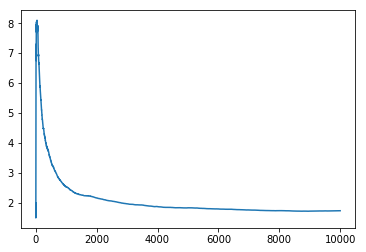

In [3]:
import matplotlib.pyplot as plt
plt.plot(store_lag[0])
plt.show()

In [ ]:
print(store_lag[0][EPISODES-5000])

In [2]:
EPISODES = 10000
print(EPISODES - 1000)

9000
